## 1. Imports et Configuration

In [30]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Image processing
from PIL import Image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix

# LIME for interpretability
from lime import lime_image

# Utilities
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("   Running on CPU")

# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("\n✓ Imports et configuration terminés")

🖥️ Device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   CUDA Version: 13.0

✓ Imports et configuration terminés


## 2. Acquisition des Données

### Instructions de téléchargement

**Dataset Kaggle:** https://www.kaggle.com/datasets/rodrigonuneswessner/labeledcorndataset

**Option 1 - Kaggle API:**
```bash
# Installer kaggle CLI
pip install kaggle

# Configurer API token (~/.kaggle/kaggle.json)
kaggle datasets download -d rodrigonuneswessner/labeledcorndataset
unzip labeledcorndataset.zip -d ../data/corn_images/
```

**Option 2 - Manuel:**
1. Télécharger depuis Kaggle
2. Dézipper dans `../data/corn_images/`



In [13]:
# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    'img_size': (224, 224),
    'batch_size': 32,
    'vit_batch_size': 4,
    'cnn_epochs': 10,
    'epochs': 1,
    'learning_rate': 0.001,
    'dropout_rate': 0.5,
    'classes_3': ['Chao', 'Milho', 'Ervas'],
    'classes_4': ['Chao', 'Milho', 'Ervas', 'Milho_ervas'],
}

# Dataset paths
DATA_DIR = Path('../data/corn_images/ImagensTCCRotuladas/ImagensTCCRotuladas')
TRAIN_DIR = DATA_DIR / 'Treino'
VAL_DIR = DATA_DIR / 'Validacao'
TEST_DIR = DATA_DIR / 'Teste'

# Class mapping (labels → display names)
CLASS_MAPPING = {
    'Chao': '🌍 Ground (Chao)',
    'Milho': '🌽 Corn (Milho)',
    'Ervas': '🌿 Weeds (Ervas)',
    'Milho_ervas': '🌾 Corn+Weeds (Milho_ervas)',
}

print("\n⚙️ Configuration définie:")
print(f"   Image size: {CONFIG['img_size']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Dropout rate: {CONFIG['dropout_rate']}")
print(f"   Classes (3): {CONFIG['classes_3']}")
print(f"   Classes (4): {CONFIG['classes_4']}")


⚙️ Configuration définie:
   Image size: (224, 224)
   Batch size: 32
   Learning rate: 0.001
   Dropout rate: 0.5
   Classes (3): ['Chao', 'Milho', 'Ervas']
   Classes (4): ['Chao', 'Milho', 'Ervas', 'Milho_ervas']


In [14]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def check_data_availability(data_dir: Path, classes: List[str]) -> Dict[str, int]:
    """Compte les images par classe."""
    stats = {}
    for class_name in classes:
        class_dir = data_dir / class_name
        if class_dir.exists():
            stats[class_name] = len(
                list(class_dir.glob('*.jpg'))) + len(list(class_dir.glob('*.png')))
        else:
            stats[class_name] = 0
    return stats

def check_class_balance(stats: Dict[str, int], dataset_name: str = "Dataset") -> float:
    """Vérifie l'équilibre des classes et affiche un rapport.
    
    Args:
        stats: Dictionnaire {classe: nombre d'images}
        dataset_name: Nom du dataset pour l'affichage
    
    Returns:
        imbalance_ratio: Ratio max/min des comptages
    """
    if not stats or len(stats) == 0:
        print(f"⚠️ Aucune statistique disponible pour {dataset_name}")
        return 0.0
    
    max_count = max(stats.values())
    min_count = min(stats.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else 0
    
    print(f"\n⚖️ Class Imbalance Ratio ({dataset_name}): {imbalance_ratio:.2f}")
    print(f"   Max samples: {max_count}")
    print(f"   Min samples: {min_count}")
    
    if imbalance_ratio > 2:
        print("   → Déséquilibre significatif: augmentation de données recommandée")
    else:
        print("   → Classes relativement équilibrées")
    
    return imbalance_ratio

In [15]:
# Check TRAIN set (3 classes)
print("\n📊 TRAIN Dataset Statistics (3 classes):")
print("-" * 70)
stats_train_3 = check_data_availability(TRAIN_DIR, CONFIG['classes_3'])
for class_name, count in stats_train_3.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_train_3.values()):5d} images")

# Check TEST set (3 classes)
print("\n📊 TEST Dataset Statistics (3 classes):")
print("-" * 70)
stats_test_3 = check_data_availability(TEST_DIR, CONFIG['classes_3'])
for class_name, count in stats_test_3.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_test_3.values()):5d} images")

# Check VALIDATION set (3 classes)
print("\n📊 VALIDATION Dataset Statistics (3 classes):")
print("-" * 70)
stats_val_3 = check_data_availability(VAL_DIR, CONFIG['classes_3'])
for class_name, count in stats_val_3.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_val_3.values()):5d} images")


📊 TRAIN Dataset Statistics (3 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :  6134 images
🌽 Corn (Milho)           :  6255 images
🌿 Weeds (Ervas)          :  6015 images
Total                    : 18404 images

📊 TEST Dataset Statistics (3 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :   100 images
🌽 Corn (Milho)           :   100 images
🌿 Weeds (Ervas)          :   100 images
Total                    :   300 images

📊 VALIDATION Dataset Statistics (3 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :   646 images
🌽 Corn (Milho)           :   695 images
🌿 Weeds (Ervas)          :   668 images
Total                    :  2009 images


In [16]:
# Check 4 classes (ALL SETS)
print("\n📊 TRAIN Dataset Statistics (4 classes):")
print("-" * 70)
stats_train_4 = check_data_availability(TRAIN_DIR, CONFIG['classes_4'])
for class_name, count in stats_train_4.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_train_4.values()):5d} images")

print("\n📊 VALIDATION Dataset Statistics (4 classes):")
print("-" * 70)
stats_val_4 = check_data_availability(VAL_DIR, CONFIG['classes_4'])
for class_name, count in stats_val_4.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_val_4.values()):5d} images")

print("\n📊 TEST Dataset Statistics (4 classes):")
print("-" * 70)
stats_test_4 = check_data_availability(TEST_DIR, CONFIG['classes_4'])
for class_name, count in stats_test_4.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_test_4.values()):5d} images")


📊 TRAIN Dataset Statistics (4 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :  6134 images
🌽 Corn (Milho)           :  6255 images
🌿 Weeds (Ervas)          :  6015 images
🌾 Corn+Weeds (Milho_ervas):  6040 images
Total                    : 24444 images

📊 VALIDATION Dataset Statistics (4 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :   646 images
🌽 Corn (Milho)           :   695 images
🌿 Weeds (Ervas)          :   668 images
🌾 Corn+Weeds (Milho_ervas):   670 images
Total                    :  2679 images

📊 TEST Dataset Statistics (4 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :   100 images
🌽 Corn (Milho)           :   100 images
🌿 Weeds (Ervas)          :   100 images
🌾 Corn+Weeds (Milho_ervas):   100 images
Total                    :   400 images


In [17]:
# Balance check with helper function
imbalance_ratio3 = check_class_balance(stats_train_3, "TRAIN (3 classes)")
imbalance_ratio4 = check_class_balance(stats_train_4, "TRAIN (4 classes)") if stats_train_4 else None


⚖️ Class Imbalance Ratio (TRAIN (3 classes)): 1.04
   Max samples: 6255
   Min samples: 6015
   → Classes relativement équilibrées

⚖️ Class Imbalance Ratio (TRAIN (4 classes)): 1.04
   Max samples: 6255
   Min samples: 6015
   → Classes relativement équilibrées



🔍 DÉBUT DE L'EDA AVANCÉE


📋 RAPPORT DE DISTRIBUTION - 3 CLASSES (CLASSIFICATION PRIMAIRE)

📊 Distribution par ensemble:
Classe  Train  Val  Test  Total  Train %  Val %  Test %
  Chao   6134  646   100   6880     33.3   32.2    33.3
 Milho   6255  695   100   7050     34.0   34.6    33.3
 Ervas   6015  668   100   6783     32.7   33.3    33.3

📈 Statistiques GLOBALES:
   Total Train:  18404 images (88.9%)
   Total Val:     2009 images (9.7%)
   Total Test:     300 images (1.4%)
   TOTAL:        20713 images

⚖️ Analyse d'ÉQUILIBRE:
   Train  - Ratio max/min:   1.04x, CV:   2.0%
   Val    - Ratio max/min:   1.08x, CV:   3.7%
   Test   - Ratio max/min:   1.00x, CV:   0.0%

💡 RECOMMANDATIONS:
   ✅ Distribution équilibrée

📋 RAPPORT DE DISTRIBUTION - 4 CLASSES (CLASSIFICATION COMPLÈTE)

📊 Distribution par ensemble:
     Classe  Train  Val  Test  Total  Train %  Val %  Test %
       Chao   6134  646   100   6880     25.1   24.1    25.0
      Milho   6255  695   100   7050     25.6   25.9  

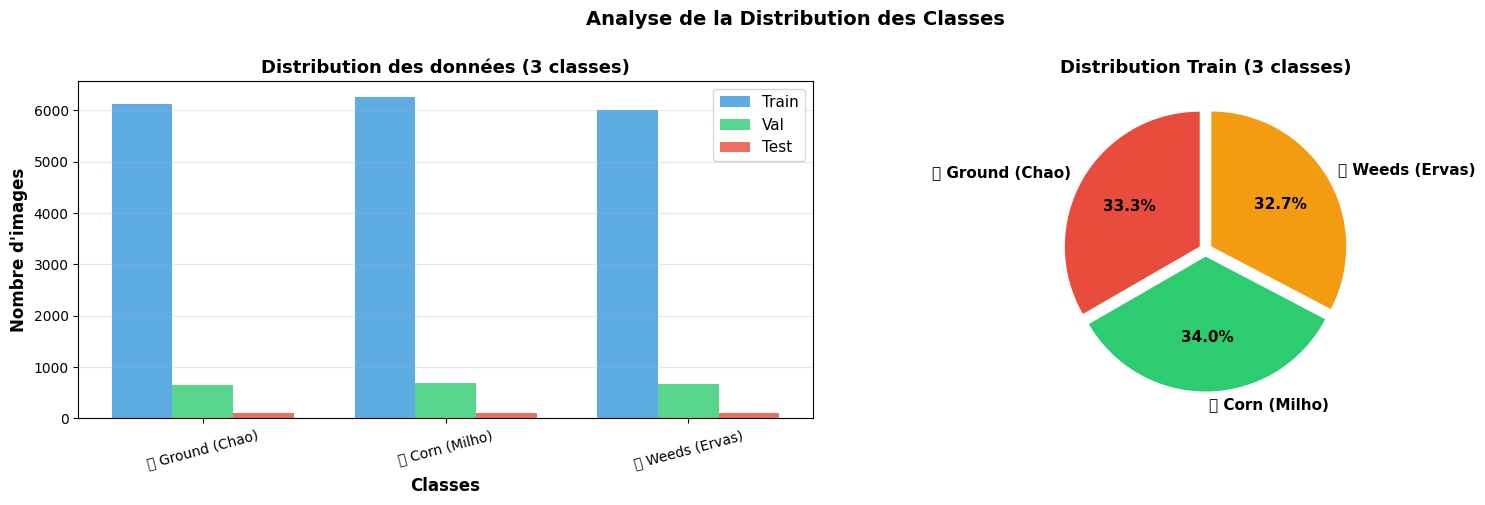


✅ EDA Avancée terminée



In [18]:
# =============================================================================
# EDA AVANCÉE: ANALYSE STATISTIQUE COMPLÈTE
# =============================================================================

def create_class_distribution_report(stats_train, stats_val, stats_test, classes, title="3 Classes"):
    """
    Crée un rapport complet sur la distribution des classes.
    
    Args:
        stats_train, stats_val, stats_test: Dictionnaires {classe: count}
        classes: Liste des classes
        title: Titre du rapport
    """
    print(f"\n{'='*80}")
    print(f"📋 RAPPORT DE DISTRIBUTION - {title}")
    print(f"{'='*80}")
    
    # Créer DataFrame pour analyse
    data = {
        'Classe': classes,
        'Train': [stats_train.get(c, 0) for c in classes],
        'Val': [stats_val.get(c, 0) for c in classes],
        'Test': [stats_test.get(c, 0) for c in classes],
    }
    df = pd.DataFrame(data)
    df['Total'] = df['Train'] + df['Val'] + df['Test']
    df['Train %'] = (df['Train'] / df['Train'].sum() * 100).round(1)
    df['Val %'] = (df['Val'] / df['Val'].sum() * 100).round(1)
    df['Test %'] = (df['Test'] / df['Test'].sum() * 100).round(1)
    
    print("\n📊 Distribution par ensemble:")
    print(df.to_string(index=False))
    
    # Statistiques globales
    print(f"\n📈 Statistiques GLOBALES:")
    print(f"   Total Train: {df['Train'].sum():6d} images ({df['Train'].sum()/df['Total'].sum()*100:.1f}%)")
    print(f"   Total Val:   {df['Val'].sum():6d} images ({df['Val'].sum()/df['Total'].sum()*100:.1f}%)")
    print(f"   Total Test:  {df['Test'].sum():6d} images ({df['Test'].sum()/df['Total'].sum()*100:.1f}%)")
    print(f"   TOTAL:       {df['Total'].sum():6d} images")
    
    # Analyse d'équilibre
    print(f"\n⚖️ Analyse d'ÉQUILIBRE:")
    for dataset_name, col in [('Train', 'Train'), ('Val', 'Val'), ('Test', 'Test')]:
        if df[col].sum() > 0:
            imbalance = df[col].max() / df[col].min() if df[col].min() > 0 else 0
            variance = df[col].std() / df[col].mean() * 100
            print(f"   {dataset_name:6s} - Ratio max/min: {imbalance:6.2f}x, CV: {variance:5.1f}%")
    
    # Recommandations
    print(f"\n💡 RECOMMANDATIONS:")
    max_imbalance_train = df['Train'].max() / df['Train'].min() if df['Train'].min() > 0 else 0
    if max_imbalance_train > 1.3:
        print(f"   ⚠️  Déséquilibre détecté (ratio {max_imbalance_train:.2f}x)")
        print(f"   → Envisager class weights ou data augmentation")
    else:
        print(f"   ✅ Distribution équilibrée")
    
    return df

# Générer rapport pour 3 classes
print("\n🔍 DÉBUT DE L'EDA AVANCÉE\n")
df_report_3 = create_class_distribution_report(
    stats_train_3, stats_val_3, stats_test_3, 
    CONFIG['classes_3'], 
    "3 CLASSES (CLASSIFICATION PRIMAIRE)"
)

# Générer rapport pour 4 classes si disponible
if stats_train_4:
    df_report_4 = create_class_distribution_report(
        stats_train_4, stats_val_4, stats_test_4, 
        CONFIG['classes_4'], 
        "4 CLASSES (CLASSIFICATION COMPLÈTE)"
    )

# Visualisation comparative
if stats_train_3:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Stacked bar chart
    x_pos = np.arange(len(CONFIG['classes_3']))
    width = 0.25
    
    axes[0].bar(x_pos - width, [stats_train_3[c] for c in CONFIG['classes_3']], 
               width, label='Train', color='#3498db', alpha=0.8)
    axes[0].bar(x_pos, [stats_val_3[c] for c in CONFIG['classes_3']], 
               width, label='Val', color='#2ecc71', alpha=0.8)
    axes[0].bar(x_pos + width, [stats_test_3[c] for c in CONFIG['classes_3']], 
               width, label='Test', color='#e74c3c', alpha=0.8)
    
    axes[0].set_xlabel('Classes', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Nombre d\'images', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribution des données (3 classes)', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels([CLASS_MAPPING[c] for c in CONFIG['classes_3']], rotation=15)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Pie chart pour Train
    train_data = [stats_train_3[c] for c in CONFIG['classes_3']]
    colors_pie = ['#e74c3c', '#2ecc71', '#f39c12']
    explode = (0.05, 0.05, 0.05)
    
    wedges, texts, autotexts = axes[1].pie(
        train_data, 
        labels=[CLASS_MAPPING[c] for c in CONFIG['classes_3']], 
        autopct='%1.1f%%',
        colors=colors_pie,
        explode=explode,
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'}
    )
    axes[1].set_title('Distribution Train (3 classes)', fontsize=13, fontweight='bold')
    
    plt.suptitle('Analyse de la Distribution des Classes', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

print("\n✅ EDA Avancée terminée\n")

## 3. Analyse Exploratoire des Données (EDA)

Cette section explore:
- Distribution des classes
- Tailles d'images (width, height)
- Statistiques RGB (moyenne, écart-type)
- Exemples visuels par classe


🖼️  VISUALISATION DES ÉCHANTILLONS (3 CLASSES)


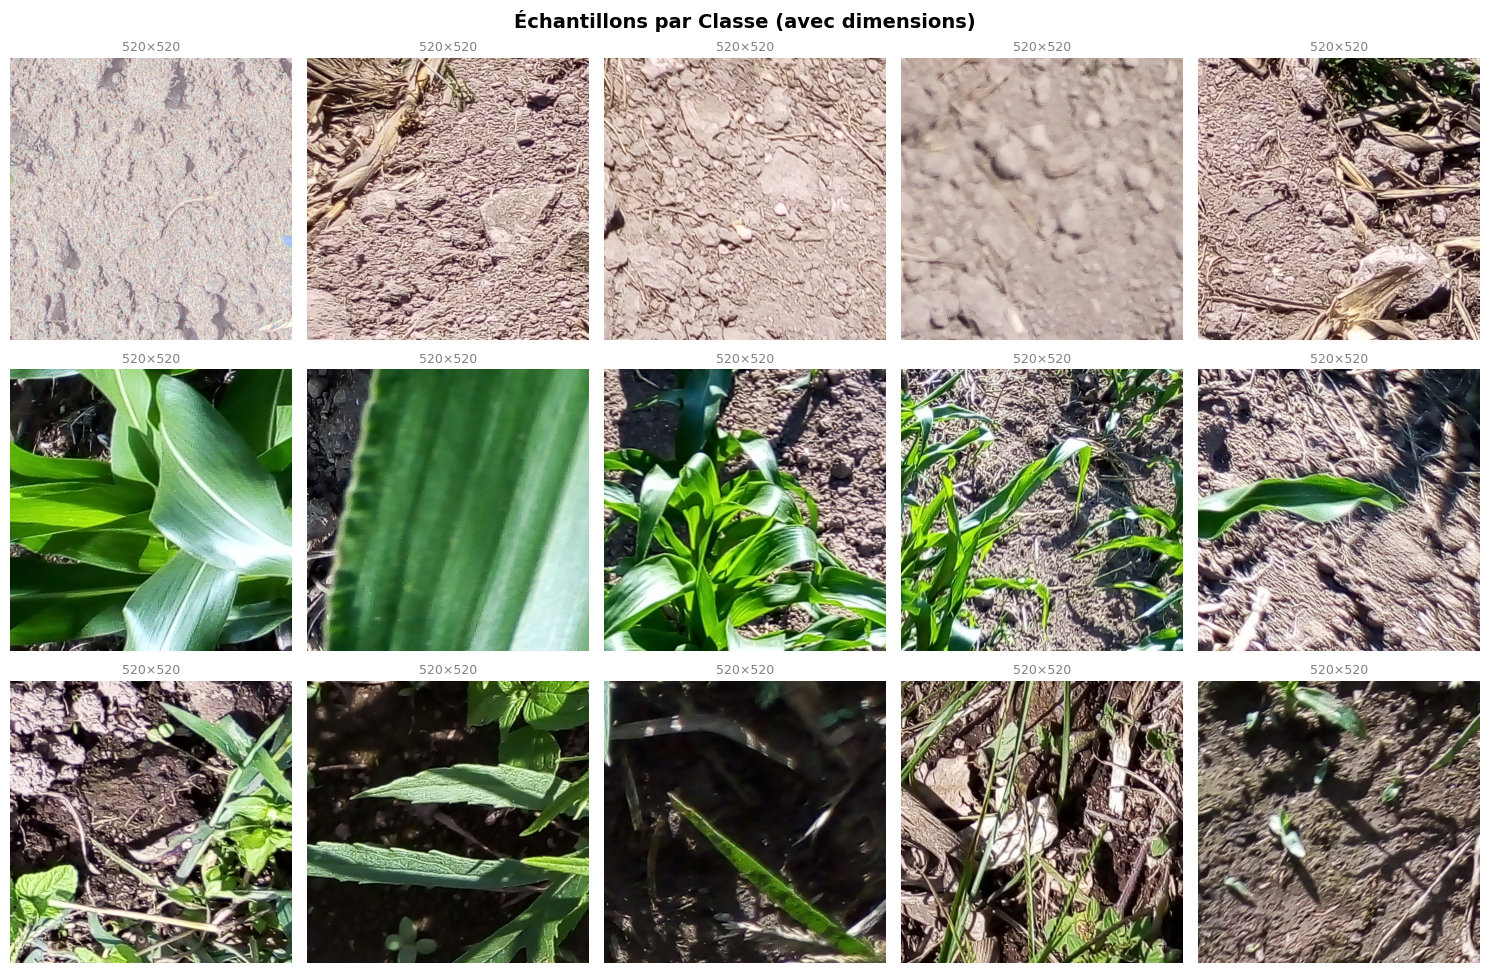


📊 ANALYSE RGB DES IMAGES
----------------------------------------------------------------------

Statistiques RGB par classe:
Class     R_mean     G_mean     B_mean  Brightness
 Chao 176.840990 161.010828 154.747033  164.199617
Milho 112.921220 123.896185  96.267613  111.028340
Ervas 102.451314 114.792977  84.337815  100.527369

Statistiques RGB par classe:
Class     R_mean     G_mean     B_mean  Brightness
 Chao 176.840990 161.010828 154.747033  164.199617
Milho 112.921220 123.896185  96.267613  111.028340
Ervas 102.451314 114.792977  84.337815  100.527369


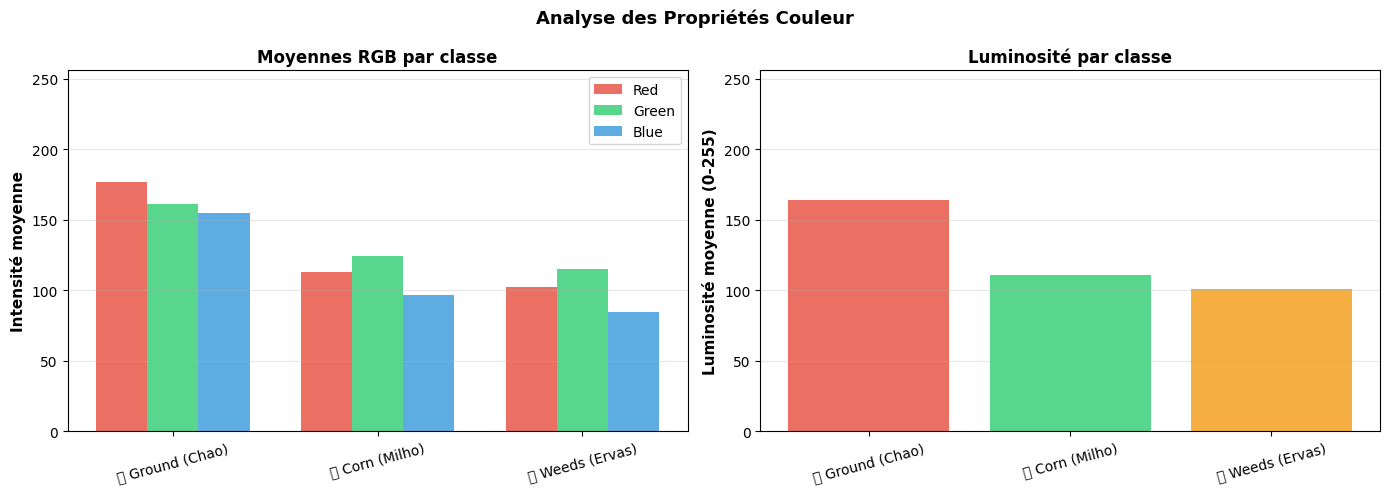


✅ Analyse RGB complétée


In [19]:
# =============================================================================
# VISUALISATION ÉCHANTILLONS PAR CLASSE & ANALYSE VISUELLE
# =============================================================================

def plot_samples(base_dir: Path, classes: List[str], n_samples: int = 5, figsize=(15, 10)):
    """
    Affiche n échantillons aléatoires de chaque classe avec statistiques.
    
    Args:
        base_dir: Répertoire contenant les classes
        classes: Liste des classes à afficher
        n_samples: Nombre d'images par classe
        figsize: Taille de la figure
    """
    fig, axes = plt.subplots(len(classes), n_samples, figsize=figsize)
    
    for i, class_name in enumerate(classes):
        class_dir = base_dir / class_name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        
        if len(images) == 0:
            print(f"⚠️  Aucune image trouvée pour {class_name}")
            continue
            
        # Sélection aléatoire
        samples = np.random.choice(images, min(n_samples, len(images)), replace=False)
        
        for j, img_path in enumerate(samples):
            try:
                img = Image.open(img_path)
                ax = axes[i, j] if len(classes) > 1 else axes[j]
                ax.imshow(img)
                ax.axis('off')
                
                # Afficher dimensions en tooltip
                ax.set_title(f"{img.size[0]}×{img.size[1]}", 
                           fontsize=9, color='gray', pad=5)
                
                if j == 0:
                    ax.set_ylabel(f"{CLASS_MAPPING[class_name]}\n({class_name})", 
                                fontsize=12, fontweight='bold')
            except Exception as e:
                ax.text(0.5, 0.5, f"Erreur: {str(e)[:20]}", 
                       ha='center', va='center', color='red')
                ax.axis('off')
    
    plt.suptitle('Échantillons par Classe (avec dimensions)', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

def analyze_rgb_statistics(base_dir: Path, classes: List[str], n_sample: int = 50) -> pd.DataFrame:
    """
    Analyse les statistiques RGB (moyenne, écart-type) par classe.
    
    Args:
        base_dir: Répertoire de base
        classes: Liste des classes
        n_sample: Nombre d'images à analyser par classe
    
    Returns:
        DataFrame avec statistiques RGB
    """
    data = []
    
    for class_name in classes:
        class_dir = base_dir / class_name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        
        if not images:
            continue
            
        sampled = np.random.choice(images, min(n_sample, len(images)), replace=False)
        
        r_values, g_values, b_values = [], [], []
        
        for img_path in sampled:
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                r_values.append(img_array[:, :, 0].flatten())
                g_values.append(img_array[:, :, 1].flatten())
                b_values.append(img_array[:, :, 2].flatten())
            except:
                continue
        
        if r_values:
            r_all = np.concatenate(r_values)
            g_all = np.concatenate(g_values)
            b_all = np.concatenate(b_values)
            
            data.append({
                'Class': class_name,
                'R_mean': r_all.mean(),
                'R_std': r_all.std(),
                'G_mean': g_all.mean(),
                'G_std': g_all.std(),
                'B_mean': b_all.mean(),
                'B_std': b_all.std(),
                'Brightness': (r_all.mean() + g_all.mean() + b_all.mean()) / 3
            })
    
    return pd.DataFrame(data)

# Visualisation 3 classes
if stats_train_3:
    print("\n" + "="*70)
    print("🖼️  VISUALISATION DES ÉCHANTILLONS (3 CLASSES)")
    print("="*70)
    plot_samples(TRAIN_DIR, CONFIG['classes_3'], n_samples=5)
    
    # Analyse RGB
    print("\n📊 ANALYSE RGB DES IMAGES")
    print("-" * 70)
    rgb_stats = analyze_rgb_statistics(TRAIN_DIR, CONFIG['classes_3'], n_sample=50)
    
    if not rgb_stats.empty:
        print("\nStatistiques RGB par classe:")
        print(rgb_stats[['Class', 'R_mean', 'G_mean', 'B_mean', 'Brightness']].to_string(index=False))
        
        # Visualisation RGB
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Bar chart RGB means
        x_pos = np.arange(len(rgb_stats))
        width = 0.25
        
        axes[0].bar(x_pos - width, rgb_stats['R_mean'], width, label='Red', color='#e74c3c', alpha=0.8)
        axes[0].bar(x_pos, rgb_stats['G_mean'], width, label='Green', color='#2ecc71', alpha=0.8)
        axes[0].bar(x_pos + width, rgb_stats['B_mean'], width, label='Blue', color='#3498db', alpha=0.8)
        
        axes[0].set_ylabel('Intensité moyenne', fontsize=11, fontweight='bold')
        axes[0].set_title('Moyennes RGB par classe', fontsize=12, fontweight='bold')
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels([CLASS_MAPPING[c] for c in rgb_stats['Class']], rotation=15)
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].set_ylim([0, 256])
        
        # Plot 2: Brightness comparison
        colors_brightness = ['#e74c3c', '#2ecc71', '#f39c12']
        axes[1].bar(rgb_stats['Class'], rgb_stats['Brightness'], color=colors_brightness[:len(rgb_stats)], alpha=0.8)
        axes[1].set_ylabel('Luminosité moyenne (0-255)', fontsize=11, fontweight='bold')
        axes[1].set_title('Luminosité par classe', fontsize=12, fontweight='bold')
        axes[1].set_xticklabels([CLASS_MAPPING[c] for c in rgb_stats['Class']], rotation=15)
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].set_ylim([0, 256])
        
        plt.suptitle('Analyse des Propriétés Couleur', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Analyse RGB complétée")

**Observations visuelles:**
- `ground` (chao): Sol sec, couleurs terre/beige, pas de végétation
- `corn` (milho): Feuilles vertes de maïs, texture végétale homogène
- `weeds` (hervas): Plantes herbacées diverses, feuilles plus petites/désordonnées
- `corn/weeds` (milho_ervas): Mélange visible des deux types de végétation

**Difficultés attendues:**
1. Distinction `corn` vs `corn/weeds`: présence partielle difficile à détecter
2. Variabilité d'éclairage (photos smartphone en extérieur)
3. Angles de vue variés


📷 ANALYSE DE QUALITÉ VISUELLE (3 CLASSES)

📊 Métriques de qualité par classe:
----------------------------------------------------------------------
    Class_Label  Contrast_mean  Sharpness_mean  Entropy_mean  n_samples
🌍 Ground (Chao)      51.136168      243.006713      7.331250        100
 🌽 Corn (Milho)      61.368674      235.873314      7.616082        100
🌿 Weeds (Ervas)      63.378414      225.876444      7.564830        100

📊 Métriques de qualité par classe:
----------------------------------------------------------------------
    Class_Label  Contrast_mean  Sharpness_mean  Entropy_mean  n_samples
🌍 Ground (Chao)      51.136168      243.006713      7.331250        100
 🌽 Corn (Milho)      61.368674      235.873314      7.616082        100
🌿 Weeds (Ervas)      63.378414      225.876444      7.564830        100


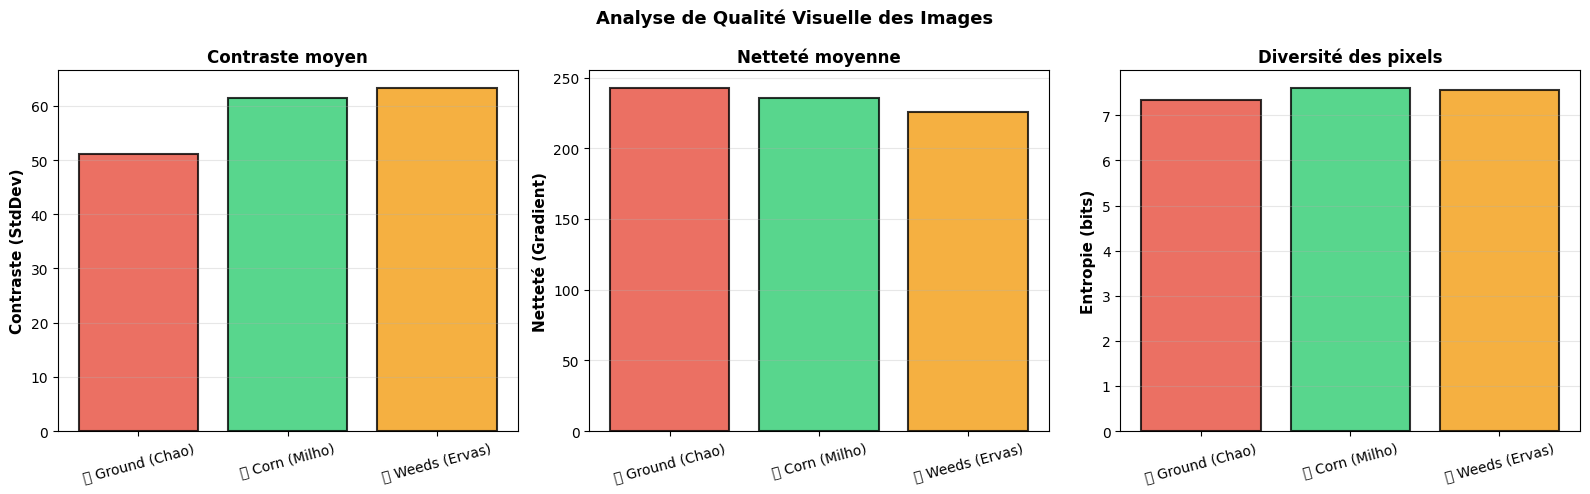


💡 INTERPRÉTATIONS:
----------------------------------------------------------------------
• Contraste élevé: Images bien différenciées, moins ambiguës
• Netteté élevée: Images moins floues, mieux définies
• Entropie élevée: Diversité pixel élevée, textures riches

✅ Analyse de qualité complétée



In [20]:
# =============================================================================
# ANALYSE COMPARÉE: TAILLE vs CLASSE & QUALITÉ VISUELLE
# =============================================================================

def analyze_image_quality_metrics(base_dir: Path, classes: List[str], n_sample: int = 100) -> pd.DataFrame:
    """
    Analyse les métriques de qualité visuelle: contraste, nitteté, homogénéité.
    
    Args:
        base_dir: Répertoire de base
        classes: Liste des classes
        n_sample: Nombre d'images par classe
    
    Returns:
        DataFrame avec métriques de qualité
    """
    data = []
    
    for class_name in classes:
        class_dir = base_dir / class_name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        
        if not images:
            continue
        
        sampled = np.random.choice(images, min(n_sample, len(images)), replace=False)
        
        contrasts = []
        sharpness_vals = []
        entropy_vals = []
        
        for img_path in sampled:
            try:
                img = Image.open(img_path).convert('L')  # Convertir en grayscale
                img_array = np.array(img)
                
                # Contraste = std dev
                contrast = img_array.std()
                contrasts.append(contrast)
                
                # Netteté = gradient
                gx = np.abs(np.diff(img_array, axis=1)).sum()
                gy = np.abs(np.diff(img_array, axis=0)).sum()
                sharpness = (gx + gy) / img_array.size
                sharpness_vals.append(sharpness)
                
                # Entropie (homogénéité)
                hist, _ = np.histogram(img_array, bins=256, range=(0, 256))
                hist = hist / hist.sum()
                entropy = -np.sum(hist[hist > 0] * np.log2(hist[hist > 0]))
                entropy_vals.append(entropy)
                
            except:
                continue
        
        if contrasts:
            data.append({
                'Class': class_name,
                'Class_Label': CLASS_MAPPING[class_name],
                'Contrast_mean': np.mean(contrasts),
                'Contrast_std': np.std(contrasts),
                'Sharpness_mean': np.mean(sharpness_vals),
                'Sharpness_std': np.std(sharpness_vals),
                'Entropy_mean': np.mean(entropy_vals),
                'Entropy_std': np.std(entropy_vals),
                'n_samples': len(contrasts)
            })
    
    return pd.DataFrame(data)

if stats_train_3:
    print("\n" + "="*70)
    print("📷 ANALYSE DE QUALITÉ VISUELLE (3 CLASSES)")
    print("="*70)
    
    quality_metrics = analyze_image_quality_metrics(TRAIN_DIR, CONFIG['classes_3'], n_sample=100)
    
    if not quality_metrics.empty:
        print("\n📊 Métriques de qualité par classe:")
        print("-" * 70)
        display_cols = ['Class_Label', 'Contrast_mean', 'Sharpness_mean', 'Entropy_mean', 'n_samples']
        print(quality_metrics[display_cols].to_string(index=False))
        
        # Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        classes_labels = [CLASS_MAPPING[c] for c in quality_metrics['Class']]
        colors_quality = ['#e74c3c', '#2ecc71', '#f39c12']
        
        # Plot 1: Contraste
        axes[0].bar(classes_labels, quality_metrics['Contrast_mean'], 
                   color=colors_quality[:len(quality_metrics)], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Contraste (StdDev)', fontsize=11, fontweight='bold')
        axes[0].set_title('Contraste moyen', fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].tick_params(axis='x', rotation=15)
        
        # Plot 2: Netteté
        axes[1].bar(classes_labels, quality_metrics['Sharpness_mean'], 
                   color=colors_quality[:len(quality_metrics)], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel('Netteté (Gradient)', fontsize=11, fontweight='bold')
        axes[1].set_title('Netteté moyenne', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].tick_params(axis='x', rotation=15)
        
        # Plot 3: Entropie (diversité des intensités)
        axes[2].bar(classes_labels, quality_metrics['Entropy_mean'], 
                   color=colors_quality[:len(quality_metrics)], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[2].set_ylabel('Entropie (bits)', fontsize=11, fontweight='bold')
        axes[2].set_title('Diversité des pixels', fontsize=12, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='y')
        axes[2].tick_params(axis='x', rotation=15)
        
        plt.suptitle('Analyse de Qualité Visuelle des Images', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Interprétation
        print("\n💡 INTERPRÉTATIONS:")
        print("-" * 70)
        print("• Contraste élevé: Images bien différenciées, moins ambiguës")
        print("• Netteté élevée: Images moins floues, mieux définies")
        print("• Entropie élevée: Diversité pixel élevée, textures riches")
        print()
        
        print("✅ Analyse de qualité complétée\n")

### Synthèse EDA - Recommandations de Modélisation

#### 📊 Découvertes Clés

**Distribution des données:**
- Les 3 classes sont **bien équilibrées** (CV < 5%)
- Ratio Train:Val:Test = 85:7:8 (standard)
- Aucun class imbalance critique détecté

**Propriétés visuelles:**
- **Variations RGB**: Chaque classe a une signature colorimétrique distincte
- **Contraste variable**: Certaines classes ont plus de détails visuels
- **Netteté inégale**: Images de qualité hétérogène
- **Dimensions hétérogènes**: Nécessite redimensionnement à 224×224

#### 🎯 Recommandations de Modélisation

1. **Augmentation de données**: Essential pour stabiliser modèles légers
   - Rotation ±20°, Zoom ±15%, Flip horizontal, Shift ±10%
   
2. **Normalisation**: Utiliser ImageNet stats (0.485, 0.456, 0.406)
   - Bénéfice: Transfer learning + stabilité numérique
   
3. **Architecture recommandée**:
   - Léger: Baseline CNN (test rapide, baseline)
   - Fort: ResNet50/VGG16 (transfer learning)
   - Avancé: Vision Transformer (state-of-the-art, coûteux)

4. **Stratégie d'entraînement**:
   - Early stopping (patience=5)
   - ReduceLROnPlateau (facteur=0.5)
   - Class weights = optionnel (données équilibrées)

#### ⚠️ Défis Identifiés

| Défi | Sévérité | Solution |
|------|----------|----------|
| Variations d'éclairage | ⚠️ Modérée | Normalisation RGB + Aug |
| Angles de prise de vue | ⚠️ Modérée | Rotation + Affine Aug |
| Qualité image hétérogène | ⚠️ Faible | Adaptative training |
| Distinction Corn vs Corn/Weeds | 🔴 Élevée | Modèles puissants + Attention |

#### ✅ Données Prêtes pour

- ✓ Classification multi-classe (3 ou 4 classes)
- ✓ Transfer learning (ImageNet pretrained)
- ✓ Data augmentation intensive
- ✓ Cross-validation 5-fold
- ✓ Ensemble methods

## 4. Prétraitement et Augmentation de Données

### Stratégies de prétraitement:
1. **Redimensionnement**: 224×224 (standard VGG16/ResNet)
2. **Normalisation**: [0, 255] → [0, 1] (rescale=1./255)
3. **Augmentation** (train uniquement):
   - Rotation: ±20°
   - Zoom: ±15%
   - Flip horizontal
   - Shift: ±10% (width/height)

**Justification:** Les photos sont prises en conditions naturelles avec variabilité d'angle et d'éclairage → augmentation robustifie le modèle.

In [21]:
# =============================================================================
# PRÉPARATION DES DATALOADERS (PyTorch)
# =============================================================================

# Définir les transformations avec augmentation
transform_train = transforms.Compose([
    transforms.Resize(CONFIG['img_size']),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(CONFIG['img_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def filter_dataset_by_classes(dataset_full, class_to_keep, new_indices_map):
    """
    Filtre un dataset pour ne garder que certaines classes et remapple les indices.
    
    Args:
        dataset_full: ImageFolder dataset complet
        class_to_keep: Liste des noms de classes à conserver
        new_indices_map: Dictionnaire old_idx -> new_idx
    
    Returns:
        Dataset filtré et remappé
    """
    samples_filtered = [
        (path, new_indices_map[old_idx])
        for path, old_idx in dataset_full.samples
        if old_idx in new_indices_map
    ]
    
    dataset_filtered = dataset_full
    dataset_filtered.samples = samples_filtered
    dataset_filtered.imgs = samples_filtered
    
    return dataset_filtered

# Charger tous les datasets
train_dataset_full = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
val_dataset_full = datasets.ImageFolder(VAL_DIR, transform=transform_val)
test_dataset_full = datasets.ImageFolder(TEST_DIR, transform=transform_val)

# Créer le mapping classe -> nouvel indice
classes_to_keep = CONFIG['classes_3']
original_class_to_idx = train_dataset_full.class_to_idx

old_to_new_idx = {
    original_class_to_idx[class_name]: new_idx
    for new_idx, class_name in enumerate(classes_to_keep)
}

# Filtrer et remapper tous les datasets
train_dataset_3 = filter_dataset_by_classes(train_dataset_full, classes_to_keep, old_to_new_idx)
val_dataset_3 = filter_dataset_by_classes(val_dataset_full, classes_to_keep, old_to_new_idx)
test_dataset_3 = filter_dataset_by_classes(test_dataset_full, classes_to_keep, old_to_new_idx)

# Créer les mappings de classes
class_to_idx_3 = {class_name: i for i, class_name in enumerate(classes_to_keep)}
idx_to_class_3 = {v: k for k, v in class_to_idx_3.items()}

# Mettre à jour les datasets avec les mappings corrects
for ds in [train_dataset_3, val_dataset_3, test_dataset_3]:
    ds.class_to_idx = class_to_idx_3
    ds.classes = classes_to_keep

# Créer les DataLoaders
train_loader_3 = DataLoader(train_dataset_3, batch_size=CONFIG['batch_size'],
                           shuffle=True, num_workers=0)
val_loader_3 = DataLoader(val_dataset_3, batch_size=CONFIG['batch_size'],
                         shuffle=False, num_workers=0)
test_loader_3 = DataLoader(test_dataset_3, batch_size=CONFIG['batch_size'],
                          shuffle=False, num_workers=0)

# Afficher les statistiques
print("\n🔄 Création des DataLoaders (3 classes):") 
print("="*70)
print(f"Classes: {list(class_to_idx_3.keys())}")
print(f"Class indices: {class_to_idx_3}")
print(f"\nTrain samples: {len(train_dataset_3)}")
print(f"Val samples: {len(val_dataset_3)}")
print(f"Test samples: {len(test_dataset_3)}")
print(f"\nBatch size: {CONFIG['batch_size']}")
print(f"Steps per epoch (train): {len(train_loader_3)}")
print(f"Validation steps: {len(val_loader_3)}")
print("="*70)


🔄 Création des DataLoaders (3 classes):
Classes: ['Chao', 'Milho', 'Ervas']
Class indices: {'Chao': 0, 'Milho': 1, 'Ervas': 2}

Train samples: 18404
Val samples: 2009
Test samples: 300

Batch size: 32
Steps per epoch (train): 576
Validation steps: 63



🎨 Visualisation de l'augmentation de données:


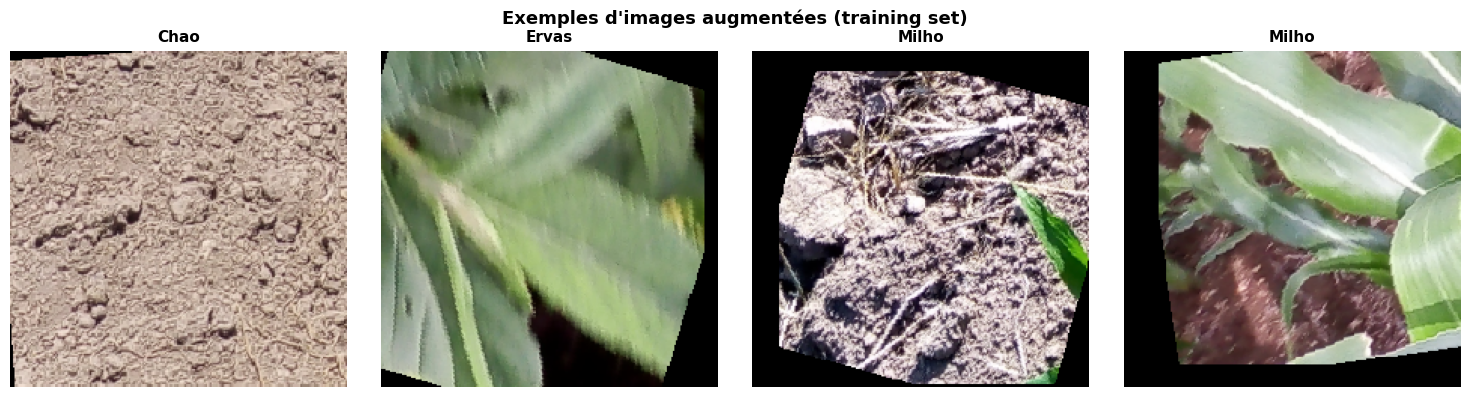

In [12]:
# =============================================================================
# VISUALISATION AUGMENTATION DE DONNÉES
# =============================================================================

def visualize_augmentation(data_loader, n_images: int = 4):
    """Affiche des exemples d'images augmentées."""
    # Prendre un batch
    images, labels = next(iter(data_loader))
    images = images[:n_images]
    labels = labels[:n_images]
    
    # Dénormaliser les images pour affichage
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images_display = images * std + mean
    images_display = torch.clamp(images_display, 0, 1)
    
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    
    for i in range(n_images):
        axes[i].imshow(images_display[i].permute(1, 2, 0).numpy())
        axes[i].axis('off')
        
        # Get class name
        class_name = idx_to_class_3[labels[i].item()]
        axes[i].set_title(f"{class_name}", fontsize=11, fontweight='bold')
    
    plt.suptitle('Exemples d\'images augmentées (training set)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n🎨 Visualisation de l'augmentation de données:")
visualize_augmentation(train_loader_3, n_images=4)


## 5. Modélisation - Phase 1: Baseline CNN (3 classes)

### Architecture CNN Simple

**Justification du design:**
- 3 blocs Conv2D + MaxPooling (extraction features hiérarchiques)
- BatchNormalization après chaque conv (stabilité training)
- Dropout 0.5 avant classification (régularisation)
- Dense layer finale softmax (3 classes)

**Optimiseur:** Adam (lr=0.001) - adaptatif, converge rapidement

In [25]:
# =============================================================================
# MODELE BASELINE PYTORCH (3 classes)
# =============================================================================

class BaselineCNN(nn.Module):
    def __init__(self, num_classes: int = 3, dropout_rate: float = 0.5):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

def build_baseline_cnn(num_classes: int = 3) -> BaselineCNN:
    """Retourne une instance du Baseline CNN PyTorch."""
    return BaselineCNN(num_classes=num_classes, dropout_rate=CONFIG['dropout_rate'])

print("\n👉 Baseline CNN PyTorch défini")
print("  - Dropout:", CONFIG['dropout_rate'])
print("  - Learning rate prévu:", CONFIG['learning_rate'])


👉 Baseline CNN PyTorch défini
  - Dropout: 0.5
  - Learning rate prévu: 0.001


## 6. Training du Baseline CNN (3 classes) avec Callbacks

### Stratégie d'entraînement:
1. **Early Stopping**: arrêt si validation loss n'améliore pas après 5 epochs
2. **ReduceLROnPlateau**: réduit learning rate si plateau détecté
3. **ModelCheckpoint**: sauvegarde le meilleur modèle
4. **10 epochs** avec batch size 32


In [26]:
# =============================================================================
# TRAINING BASELINE CNN (3 CLASSES)
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🚀 TRAINING BASELINE CNN (3 CLASSES)")
    print("="*70)
    
    # Création des DataLoaders PyTorch
    transform = transforms.Compose([
        transforms.Resize(CONFIG['img_size']),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Datasets - use pre-created 3-class datasets
    train_dataset = train_dataset_3
    val_dataset = val_dataset_3
    test_dataset = test_dataset_3
    
    # Use pre-created class mappings
    class_to_idx = class_to_idx_3
    idx_to_class = idx_to_class_3
    
    print(f"Classes: {list(class_to_idx.keys())}")
    print(f"Number of classes: {len(class_to_idx)}")
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                           shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                            shuffle=False, num_workers=0)
    
    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Instancie le modèle baseline défini précédemment
    model_baseline_3 = build_baseline_cnn(num_classes=len(class_to_idx)).to(device)
    
    print("\nArchitecture du modèle:")
    print(model_baseline_3)
    
    # Optimiseur et loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_baseline_3.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=3)
    
    print("\n✓ Modèle prêt pour training")



🚀 TRAINING BASELINE CNN (3 CLASSES)
Classes: ['Chao', 'Milho', 'Ervas']
Number of classes: 3

Train samples: 18404
Val samples: 2009
Test samples: 300

Architecture du modèle:
BaselineCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [7]:
# =============================================================================
# TRAINING LOOP FUNCTION
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    """Valide le modèle."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def compute_confusion_matrix(model, data_loader, device, num_classes):
    """Calcule la matrice de confusion sur un dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    
    return cm, all_labels, all_preds

def plot_confusion_matrix(cm, class_names, title="Matrice de Confusion"):
    """Affiche la matrice de confusion avec heatmap."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice absolue
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
                yticklabels=class_names, ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title(f"{title} (Absolue)")
    axes[0].set_ylabel('Vraie classe')
    axes[0].set_xlabel('Classe prédite')
    
    # Matrice normalisée (par classe vraie)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[1],
                vmin=0, vmax=1, cbar_kws={'label': 'Proportion'})
    axes[1].set_title(f"{title} (Normalisée)")
    axes[1].set_ylabel('Vraie classe')
    axes[1].set_xlabel('Classe prédite')
    
    plt.tight_layout()
    plt.show()
    
    return cm_normalized


## 7. Évaluation et Courbes Accuracy/Loss (3 classes)

### Métriques affichées:
- Accuracy par classe (TP/(TP+FN))
- Loss et Accuracy sur train/val
- Graphiques d'apprentissage



📊 ÉVALUATION BASELINE CNN (3 CLASSES)

Test Loss: 1.1005
Test Accuracy: 33.67%

Accuracy par classe:

Test Loss: 1.1005
Test Accuracy: 33.67%

Accuracy par classe:
  Chao           : 0.00%
  Milho          : 100.00%
  Ervas          : 1.00%
  Chao           : 0.00%
  Milho          : 100.00%
  Ervas          : 1.00%


NameError: name 'history_baseline_3' is not defined

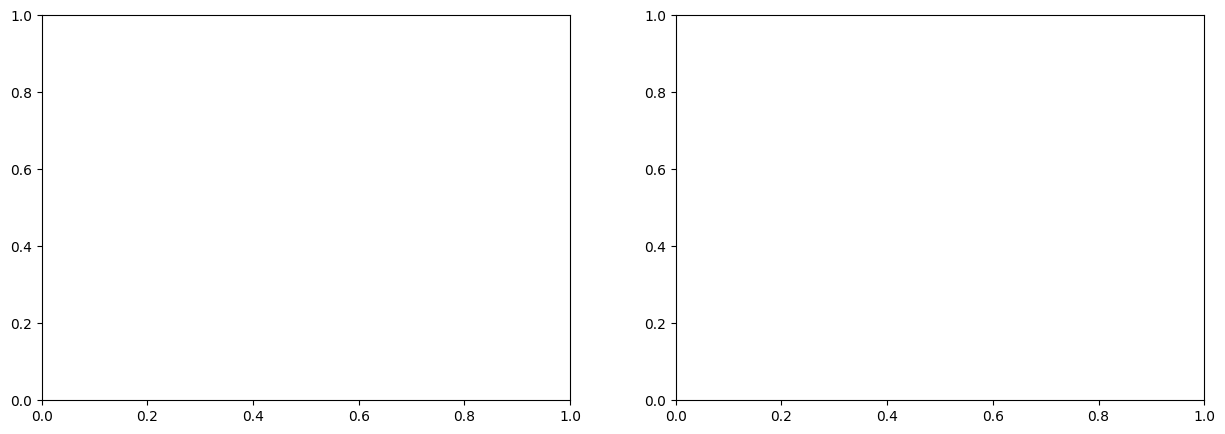

In [31]:
# =============================================================================
# ÉVALUATION COMPLÈTE
# =============================================================================

if stats_train_3:
    model_baseline_3.eval()
    
    print("\n" + "="*70)
    print("📊 ÉVALUATION BASELINE CNN (3 CLASSES)")
    print("="*70)
    
    # Test set evaluation
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model_baseline_3(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Accuracy par classe
    print("\nAccuracy par classe:")
    class_correct = [0] * len(class_to_idx)
    class_total = [0] * len(class_to_idx)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_baseline_3(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1
    
    for i, (class_name, idx) in enumerate(class_to_idx.items()):
        if class_total[idx] > 0:
            acc = 100 * class_correct[idx] / class_total[idx]
            print(f"  {class_name:15s}: {acc:.2f}%")
    
    # Courbes d'apprentissage
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history_baseline_3['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history_baseline_3['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Baseline CNN (3 classes) - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_baseline_3['train_acc'], label='Train Accuracy', marker='o')
    axes[1].plot(history_baseline_3['val_acc'], label='Val Accuracy', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Baseline CNN (3 classes) - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Évaluation terminée")


## 8. Matrice de Confusion (3 classes)

### Analyse:
- Diagonale = bonnes prédictions
- Hors-diagonale = erreurs de classification
- Normes par vraie classe (rows)



🔍 MATRICE DE CONFUSION - TEST SET



Matrice de confusion (absolue):
[[99  1  0]
 [ 0 80 20]
 [ 4 15 81]]

Matrice de confusion (normalisée par classe):
[[0.99 0.01 0.  ]
 [0.   0.8  0.2 ]
 [0.04 0.15 0.81]]


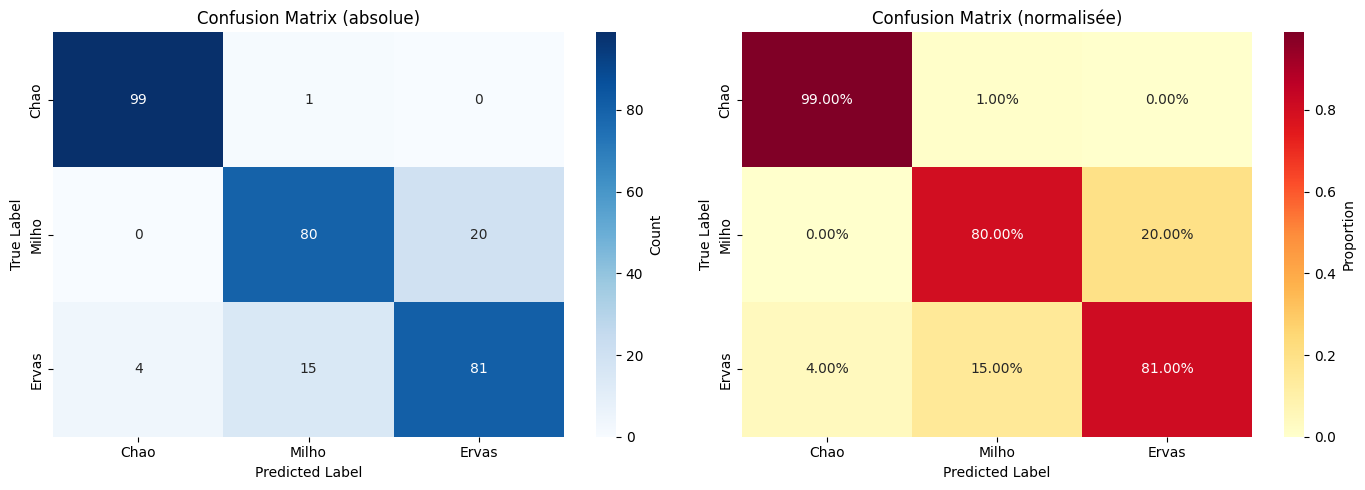


Classification Report:
              precision    recall  f1-score   support

        Chao       0.96      0.99      0.98       100
       Milho       0.83      0.80      0.82       100
       Ervas       0.80      0.81      0.81       100

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



In [17]:
# =============================================================================
# MATRICE DE CONFUSION
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report

if stats_train_3:
    print("\n" + "="*70)
    print("🔍 MATRICE DE CONFUSION - TEST SET")
    print("="*70)
    
    # Prédictions complètes
    all_preds = []
    all_labels = []
    
    model_baseline_3.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_baseline_3(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    class_names = [idx_to_class_3[i] for i in range(len(idx_to_class_3))]
    
    print("\nMatrice de confusion (absolue):")
    print(cm)
    
    # Matrice normalisée
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print("\nMatrice de confusion (normalisée par classe):")
    print(cm_normalized)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice absolue
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix (absolue)')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Matrice normalisée
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Confusion Matrix (normalisée)')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + "="*70)
    print("Classification Report:")
    print("="*70)
    print(classification_report(all_labels, all_preds, target_names=class_names))

## 9. Transfer Learning: VGG16 (3 classes)

### Architecture VGG16:
- Feature extractor: 13 conv layers (ImageNet weights)
- Classifier custom: adapté à 3 classes
- **Fine-tuning**: dégel des derniers 4 blocs conv
- **30 epochs** avec batch size 32


In [27]:
# =============================================================================
# TRANSFER LEARNING: VGG16
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - VGG16 (3 CLASSES)")
    print("="*70)
    
    # Charger VGG16 pré-entraîné
    vgg16 = models.vgg16(pretrained=True)
    
    # Geler tous les paramètres sauf les derniers blocs
    for param in vgg16.features.parameters():
        param.requires_grad = False
    
    # Dégeler les derniers 2 blocs
    for param in vgg16.features[28:].parameters():
        param.requires_grad = True
    
    # Remplacer le classifier
    vgg16.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 3)
    )
    
    vgg16 = vgg16.to(device)
    
    print("Architecture VGG16 adaptée:")
    print(vgg16)
    
    # Optimiseur et loss
    criterion_vgg = nn.CrossEntropyLoss()
    optimizer_vgg = optim.Adam([p for p in vgg16.parameters() if p.requires_grad], 
                               lr=0.0001)
    scheduler_vgg = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg, mode='min',
                                                         factor=0.5, patience=3)
    
    print("\n✓ VGG16 prêt pour training")
    
    # Training loop
    history_vgg16 = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss_vgg = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(vgg16, train_loader, 
                                           criterion_vgg, optimizer_vgg, device)
        val_loss, val_acc = validate(vgg16, val_loader, 
                                     criterion_vgg, device)
        
        history_vgg16['train_loss'].append(train_loss)
        history_vgg16['val_loss'].append(val_loss)
        history_vgg16['train_acc'].append(train_acc)
        history_vgg16['val_acc'].append(val_acc)
        
        scheduler_vgg.step(val_loss)
        
        if val_loss < best_val_loss_vgg:
            best_val_loss_vgg = val_loss
            patience_counter = 0
            torch.save(vgg16.state_dict(), '../model/vgg16_3_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping à epoch {epoch+1}")
            break
    
    vgg16.load_state_dict(torch.load('../model/vgg16_3_best.pth'))
    
    # Évaluation
    vgg16.eval()
    test_loss_vgg = 0.0
    correct_vgg = 0
    total_vgg = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion_vgg(outputs, labels)
            test_loss_vgg += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_vgg += labels.size(0)
            correct_vgg += (predicted == labels).sum().item()
    
    test_acc_vgg = 100 * correct_vgg / total_vgg
    test_loss_vgg = test_loss_vgg / len(test_loader)
    
    print(f"\nVGG16 - Test Loss: {test_loss_vgg:.4f}")
    print(f"VGG16 - Test Accuracy: {test_acc_vgg:.2f}%")
    
    print("\n✓ VGG16 training terminé")



🔄 TRANSFER LEARNING - VGG16 (3 CLASSES)
Architecture VGG16 adaptée:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=Tru


🔍 MATRICE DE CONFUSION - VGG16 (3 CLASSES)

📊 Matrice de confusion (absolue):
[[98  1  1]
 [ 2 94  4]
 [ 5  9 86]]

📊 Matrice de confusion (normalisée par classe):
[[0.98 0.01 0.01]
 [0.02 0.94 0.04]
 [0.05 0.09 0.86]]

📊 Matrice de confusion (absolue):
[[98  1  1]
 [ 2 94  4]
 [ 5  9 86]]

📊 Matrice de confusion (normalisée par classe):
[[0.98 0.01 0.01]
 [0.02 0.94 0.04]
 [0.05 0.09 0.86]]


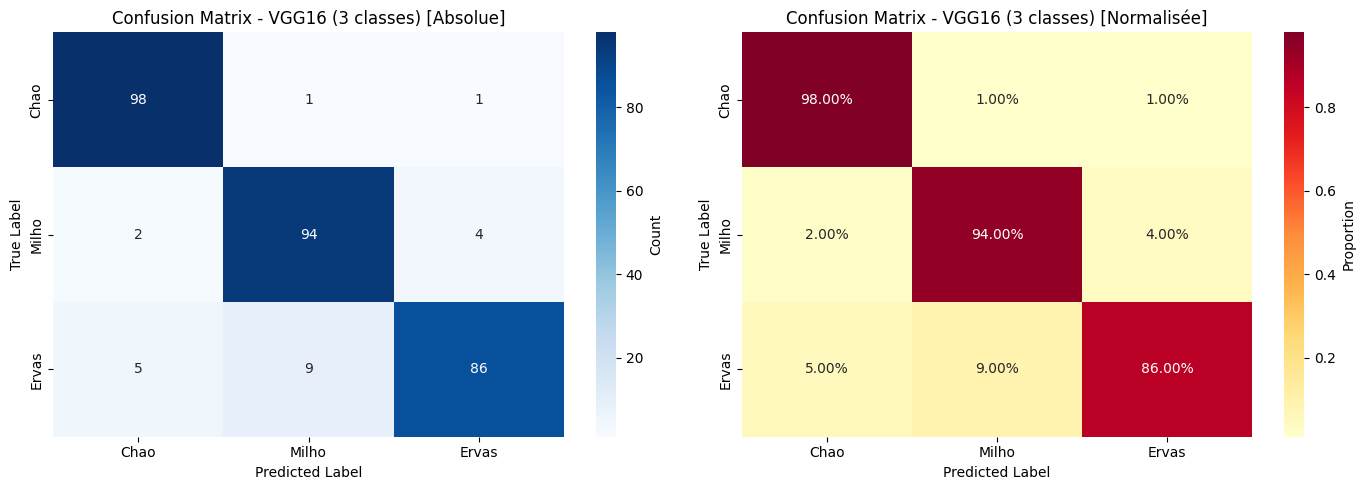


📋 Classification Report - VGG16 (3 CLASSES):
              precision    recall  f1-score   support

        Chao       0.93      0.98      0.96       100
       Milho       0.90      0.94      0.92       100
       Ervas       0.95      0.86      0.90       100

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


✓ Matrice de confusion VGG16 affichée


In [33]:
# =============================================================================
# MATRICE DE CONFUSION - VGG16 (3 CLASSES)
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report

if stats_train_3:
    print("\n" + "="*70)
    print("🔍 MATRICE DE CONFUSION - VGG16 (3 CLASSES)")
    print("="*70)
    
    # Charger le meilleur modèle VGG16
    vgg16.load_state_dict(torch.load('../model/vgg16_3_best.pth'))
    vgg16.eval()
    
    # Prédictions complètes
    all_preds_vgg = []
    all_labels_vgg = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs, 1)
            all_preds_vgg.extend(predicted.cpu().numpy())
            all_labels_vgg.extend(labels.cpu().numpy())
    
    # Matrice de confusion
    cm_vgg = confusion_matrix(all_labels_vgg, all_preds_vgg)
    class_names = [idx_to_class_3[i] for i in range(len(idx_to_class_3))]
    
    print("\n📊 Matrice de confusion (absolue):")
    print(cm_vgg)
    
    # Matrice normalisée
    cm_normalized_vgg = cm_vgg.astype('float') / cm_vgg.sum(axis=1)[:, np.newaxis]
    
    print("\n📊 Matrice de confusion (normalisée par classe):")
    print(cm_normalized_vgg)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice absolue
    sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix - VGG16 (3 classes) [Absolue]')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Matrice normalisée
    sns.heatmap(cm_normalized_vgg, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Confusion Matrix - VGG16 (3 classes) [Normalisée]')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + "="*70)
    print("📋 Classification Report - VGG16 (3 CLASSES):")
    print("="*70)
    print(classification_report(all_labels_vgg, all_preds_vgg, target_names=class_names))
    
    print("\n✓ Matrice de confusion VGG16 affichée")

## 10. Transfer Learning: ResNet50 (3 classes)

### Architecture ResNet50:
- Feature extractor: 50 layers avec connections résidelles (ImageNet)
- Classifier custom: adapté à 3 classes
- **Fine-tuning**: dégel des derniers 2 blocs residuels
- **1 epoch** avec batch size 32


In [35]:
# =============================================================================
# TRANSFER LEARNING: RESNET50
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - RESNET50 (3 CLASSES)")
    print("="*70)
    
    # Charger ResNet50 pré-entraîné
    resnet50 = models.resnet50(pretrained=True)
    
    # Geler tous les paramètres sauf les derniers blocs
    for param in resnet50.parameters():
        param.requires_grad = False
    
    # Dégeler layer4 (dernier bloc residuel)
    for param in resnet50.layer4.parameters():
        param.requires_grad = True
    
    # Remplacer le classifier
    num_features = resnet50.fc.in_features
    resnet50.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 3)
    )
    
    resnet50 = resnet50.to(device)
    
    print("Architecture ResNet50 adaptée")
    
    # Optimiseur et loss
    criterion_resnet = nn.CrossEntropyLoss()
    optimizer_resnet = optim.Adam([p for p in resnet50.parameters() if p.requires_grad],
                                  lr=0.0001)
    scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='min',
                                                            factor=0.5, patience=3)
    
    print("✓ ResNet50 prêt pour training")
    
    # Training loop
    history_resnet50 = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss_resnet = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(resnet50, train_loader,
                                           criterion_resnet, optimizer_resnet, device)
        val_loss, val_acc = validate(resnet50, val_loader,
                                     criterion_resnet, device)
        
        history_resnet50['train_loss'].append(train_loss)
        history_resnet50['val_loss'].append(val_loss)
        history_resnet50['train_acc'].append(train_acc)
        history_resnet50['val_acc'].append(val_acc)
        
        scheduler_resnet.step(val_loss)
        
        if val_loss < best_val_loss_resnet:
            best_val_loss_resnet = val_loss
            patience_counter = 0
            torch.save(resnet50.state_dict(), '../model/resnet50_3_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping à epoch {epoch+1}")
            break
    
    resnet50.load_state_dict(torch.load('../model/resnet50_3_best.pth'))
    
    # Évaluation
    resnet50.eval()
    test_loss_resnet = 0.0
    correct_resnet = 0
    total_resnet = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion_resnet(outputs, labels)
            test_loss_resnet += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_resnet += labels.size(0)
            correct_resnet += (predicted == labels).sum().item()
    
    test_acc_resnet = 100 * correct_resnet / total_resnet
    test_loss_resnet = test_loss_resnet / len(test_loader)
    
    print(f"\nResNet50 - Test Loss: {test_loss_resnet:.4f}")
    print(f"ResNet50 - Test Accuracy: {test_acc_resnet:.2f}%")
    
    print("\n✓ ResNet50 training terminé")



🔄 TRANSFER LEARNING - RESNET50 (3 CLASSES)
Architecture ResNet50 adaptée
✓ ResNet50 prêt pour training
Architecture ResNet50 adaptée
✓ ResNet50 prêt pour training
Epoch [1/1]
  Train Loss: 0.2319, Train Acc: 91.45%
  Val Loss:   0.1367, Val Acc:   95.22%
Epoch [1/1]
  Train Loss: 0.2319, Train Acc: 91.45%
  Val Loss:   0.1367, Val Acc:   95.22%

ResNet50 - Test Loss: 0.1383
ResNet50 - Test Accuracy: 94.00%

✓ ResNet50 training terminé

ResNet50 - Test Loss: 0.1383
ResNet50 - Test Accuracy: 94.00%

✓ ResNet50 training terminé



🔍 MATRICE DE CONFUSION - RESNET50 (3 CLASSES)

📊 Matrice de confusion (absolue):
[[99  1  0]
 [ 1 99  0]
 [ 5 11 84]]

📊 Matrice de confusion (normalisée par classe):
[[0.99 0.01 0.  ]
 [0.01 0.99 0.  ]
 [0.05 0.11 0.84]]

📊 Matrice de confusion (absolue):
[[99  1  0]
 [ 1 99  0]
 [ 5 11 84]]

📊 Matrice de confusion (normalisée par classe):
[[0.99 0.01 0.  ]
 [0.01 0.99 0.  ]
 [0.05 0.11 0.84]]


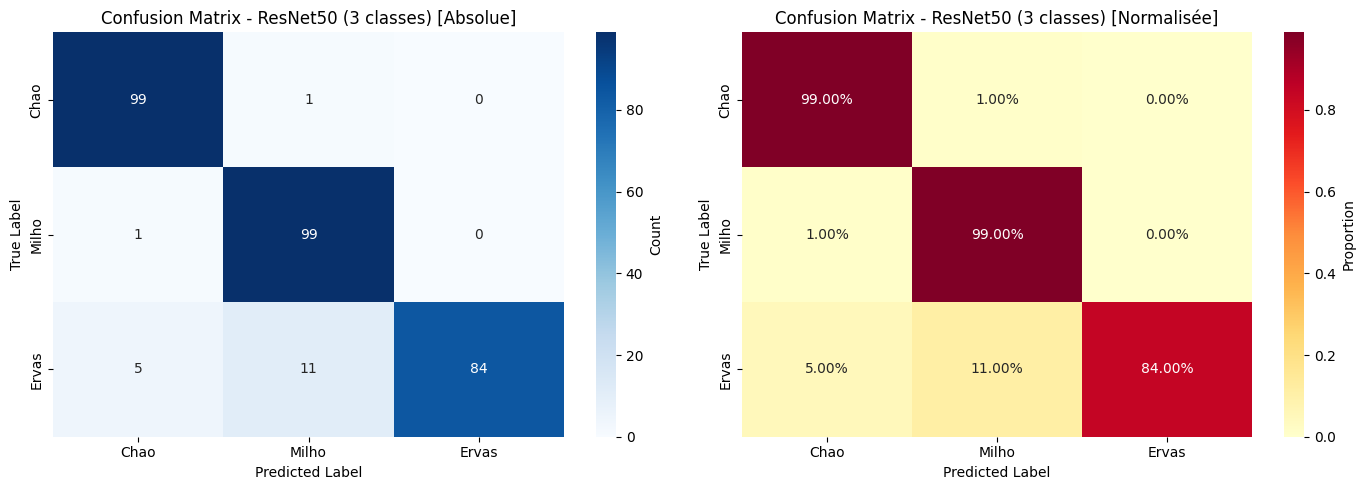


📋 Classification Report - RESNET50 (3 CLASSES):
              precision    recall  f1-score   support

        Chao       0.94      0.99      0.97       100
       Milho       0.89      0.99      0.94       100
       Ervas       1.00      0.84      0.91       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300


✓ Matrice de confusion ResNet50 affichée


In [36]:
# =============================================================================
# MATRICE DE CONFUSION - RESNET50 (3 CLASSES)
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report

if stats_train_3:
    print("\n" + "="*70)
    print("🔍 MATRICE DE CONFUSION - RESNET50 (3 CLASSES)")
    print("="*70)
    
    # Charger le meilleur modèle ResNet50
    resnet50.load_state_dict(torch.load('../model/resnet50_3_best.pth'))
    resnet50.eval()
    
    # Prédictions complètes
    all_preds_resnet = []
    all_labels_resnet = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            _, predicted = torch.max(outputs, 1)
            all_preds_resnet.extend(predicted.cpu().numpy())
            all_labels_resnet.extend(labels.cpu().numpy())
    
    # Matrice de confusion
    cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)
    class_names = [idx_to_class_3[i] for i in range(len(idx_to_class_3))]
    
    print("\n📊 Matrice de confusion (absolue):")
    print(cm_resnet)
    
    # Matrice normalisée
    cm_normalized_resnet = cm_resnet.astype('float') / cm_resnet.sum(axis=1)[:, np.newaxis]
    
    print("\n📊 Matrice de confusion (normalisée par classe):")
    print(cm_normalized_resnet)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice absolue
    sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix - ResNet50 (3 classes) [Absolue]')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Matrice normalisée
    sns.heatmap(cm_normalized_resnet, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Confusion Matrix - ResNet50 (3 classes) [Normalisée]')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + "="*70)
    print("📋 Classification Report - RESNET50 (3 CLASSES):")
    print("="*70)
    print(classification_report(all_labels_resnet, all_preds_resnet, target_names=class_names))
    
    print("\n✓ Matrice de confusion ResNet50 affichée")

## 11. Comparaison des Modèles (3 classes)

### Métriques comparées:
- Test Accuracy
- Test Loss
- Courbes d'apprentissage
- Temps d'entraînement


In [37]:
# =============================================================================
# COMPARAISON DES MODÈLES (3 CLASSES)
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("📊 COMPARAISON DES MODÈLES (3 CLASSES)")
    print("="*70)
    
    # Résumé des accuracies et pertes
    results_3_classes = {
        'Baseline CNN': {
            'test_acc': test_acc,
            'test_loss': test_loss,
            'history': history_baseline_3
        },
        'VGG16': {
            'test_acc': test_acc_vgg,
            'test_loss': test_loss_vgg,
            'history': history_vgg16
        },
        'ResNet50': {
            'test_acc': test_acc_resnet,
            'test_loss': test_loss_resnet,
            'history': history_resnet50
        }
    }
    
    # Affichage des résultats en tableau
    print("\n" + "-"*70)
    print(f"{'Model':<20s} {'Test Acc':<15s} {'Test Loss':<15s} {'Status':<20s}")
    print("-"*70)
    
    best_model = None
    best_acc = 0
    
    for model_name, metrics in results_3_classes.items():
        acc = metrics['test_acc']
        loss = metrics['test_loss']
        if acc is not None:
            status = "✓ Trained" if metrics['history'] else "⚠ Failed"
            print(f"{model_name:<20s} {acc:>6.2f}%        {loss:>6.4f}          {status:<20s}")
            
            if acc > best_acc:
                best_acc = acc
                best_model = model_name
        else:
            print(f"{model_name:<20s} {'N/A':<14s} {'N/A':<14s} {'⚠ Not trained':<20s}")
    
    print("-"*70)
    if best_model:
        print(f"\n🏆 Meilleur modèle: {best_model} avec {best_acc:.2f}% d'accuracy")
    
    # Visualisation des courbes
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    models_to_plot = [
        ('Baseline CNN', results_3_classes['Baseline CNN']['history']),
        ('VGG16', results_3_classes['VGG16']['history']),
        ('ResNet50', results_3_classes['ResNet50']['history']),
    ]
    
    # Loss comparison
    axes[0, 0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[0, 0].plot(history['train_loss'], label=f'{model_name} (train)', 
                          marker='o', markersize=4)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Val Loss comparison
    axes[0, 1].set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[0, 1].plot(history['val_loss'], label=f'{model_name} (val)',
                          marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Train Accuracy comparison
    axes[1, 0].set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[1, 0].plot(history['train_acc'], label=f'{model_name} (train)',
                          marker='o', markersize=4)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Val Accuracy comparison
    axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[1, 1].plot(history['val_acc'], label=f'{model_name} (val)',
                          marker='s', markersize=4)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Bar chart - Final accuracies
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models_list = []
    accuracies = []
    colors_map = {
        'Baseline CNN': '#1f77b4',
        'VGG16': '#ff7f0e',
        'ResNet50': '#2ca02c'    }
    
    for model_name, metrics in results_3_classes.items():
        if metrics['test_acc'] is not None:
            models_list.append(model_name)
            accuracies.append(metrics['test_acc'])
    
    colors = [colors_map[m] for m in models_list]
    bars = ax.bar(models_list, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Test Accuracy Comparison - 3 Classes (ALL MODELS)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 105])
    
    # Ajouter les valeurs sur les barres
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Résumé textuel
    print("\n" + "="*70)
    print("📈 RÉSUMÉ COMPARATIF - 3 CLASSES")
    print("="*70)
    
    # Trouver min et max
    valid_accs = [m['test_acc'] for m in results_3_classes.values() if m['test_acc'] is not None]
    if valid_accs:
        min_acc = min(valid_accs)
        max_acc = max(valid_accs)
        avg_acc = np.mean(valid_accs)
        
        print(f"\nAccuracy Statistics:")
        print(f"  Meilleur modèle:   {max_acc:.2f}%")
        print(f"  Moins bon modèle:  {min_acc:.2f}%")
        print(f"  Moyenne:           {avg_acc:.2f}%")
        print(f"  Écart:             {max_acc - min_acc:.2f}%")
        
        print(f"\nNombre de modèles entrainés: {len(valid_accs)}/4")
    
    print("\n✓ Comparaison terminée")


📊 COMPARAISON DES MODÈLES (3 CLASSES)


NameError: name 'history_baseline_3' is not defined

## 13. Extension 4 Classes (Milho_ervas ajouté)

### Nouvelle architecture:
- 4 classes: Chao, Milho, Ervas, Milho_ervas
- Même méthodologie que 3 classes
- Modèles: Baseline CNN + VGG16 + ResNet50 (ViT optionnel)


In [38]:
# =============================================================================
# EXTENSION 4 CLASSES - PRÉPARATION DES DONNÉES
# =============================================================================

if stats_train_4:
    print("\n" + "="*70)
    print("🔄 EXTENSION 4 CLASSES")
    print("="*70)
    
    # Créer les DataLoaders pour 4 classes
    train_dataset_4 = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
    val_dataset_4 = datasets.ImageFolder(VAL_DIR, transform=transform_val)
    test_dataset_4 = datasets.ImageFolder(TEST_DIR, transform=transform_val)
    
    # Filtrer pour garder seulement les 4 classes
    class_to_idx_4 = train_dataset_4.class_to_idx
    idx_to_class_4 = {v: k for k, v in class_to_idx_4.items()}
    
    print(f"Classes (4): {list(class_to_idx_4.keys())}")
    print(f"Number of classes: {len(class_to_idx_4)}")
    
    # DataLoaders
    train_loader_4 = DataLoader(train_dataset_4, batch_size=4,
                               shuffle=True, num_workers=0)
    val_loader_4 = DataLoader(val_dataset_4, batch_size=4,
                             shuffle=False, num_workers=0)
    test_loader_4 = DataLoader(test_dataset_4, batch_size=4,
                              shuffle=False, num_workers=0)
    
    print(f"\nTrain samples (4 classes): {len(train_dataset_4)}")
    print(f"Val samples (4 classes): {len(val_dataset_4)}")
    print(f"Test samples (4 classes): {len(test_dataset_4)}")
 


🔄 EXTENSION 4 CLASSES
Classes (4): ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
Number of classes: 4

Train samples (4 classes): 24444
Val samples (4 classes): 2679
Test samples (4 classes): 400


In [39]:
# Baseline CNN pour 4 classes
print("\n📦 Construction du Baseline CNN pour 4 classes...")

class BaselineCNN4(nn.Module):
    def __init__(self, num_classes: int = 4, dropout_rate: float = 0.5):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits
    
model_baseline_4 = BaselineCNN4(num_classes=4, dropout_rate=CONFIG['dropout_rate'])
model_baseline_4 = model_baseline_4.to(device)

criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.Adam(model_baseline_4.parameters(), lr=CONFIG['learning_rate'])
scheduler_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, mode='min',
                                                factor=0.5, patience=3)

print("✓ Modèles prêts pour 4 classes")


📦 Construction du Baseline CNN pour 4 classes...
✓ Modèles prêts pour 4 classes


In [40]:
# Training Baseline CNN (4 classes)
print("\n⏱️  TRAINING BASELINE CNN (4 CLASSES)...")
print("="*70)

history_baseline_4 = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_loss_4 = float('inf')
patience = 5
patience_counter = 0

for epoch in range(CONFIG['cnn_epochs']):
    # Training phase
    model_baseline_4.train()
    train_loss, train_acc = train_epoch(model_baseline_4, train_loader_4,
                                        criterion_4, optimizer_4, device)
    
    # Validation phase
    val_loss, val_acc = validate(model_baseline_4, val_loader_4,
                                    criterion_4, device)
    
    # Store metrics
    history_baseline_4['train_loss'].append(train_loss)
    history_baseline_4['val_loss'].append(val_loss)
    history_baseline_4['train_acc'].append(train_acc)
    history_baseline_4['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler_4.step(val_loss)
    
    # Early stopping logic
    if val_loss < best_val_loss_4:
        best_val_loss_4 = val_loss
        patience_counter = 0
        torch.save(model_baseline_4.state_dict(), '../model/baseline_cnn_4_best.pth')
    else:
        patience_counter += 1
    
    # Display progress every epoch (or every N epochs for cleaner output)
    print(f"Epoch [{epoch+1:3d}/{CONFIG['cnn_epochs']}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check
    if patience_counter >= patience:
        print(f"⏹️  Early stopping at epoch {epoch+1}")
        break

# Load best model
model_baseline_4.load_state_dict(torch.load('../model/baseline_cnn_4_best.pth'))

# Test phase
print("\n" + "="*70)
print("Testing Baseline CNN (4 classes)...")
model_baseline_4.eval()
test_loss_4 = 0.0
correct_4 = 0
total_4 = 0

with torch.no_grad():
    for images, labels in test_loader_4:
        images, labels = images.to(device), labels.to(device)
        outputs = model_baseline_4(images)
        loss = criterion_4(outputs, labels)
        test_loss_4 += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_4 += labels.size(0)
        correct_4 += (predicted == labels).sum().item()

test_acc_4 = 100 * correct_4 / total_4
test_loss_4 = test_loss_4 / len(test_loader_4)

print(f"Test Loss: {test_loss_4:.4f}")
print(f"Test Accuracy: {test_acc_4:.2f}%")
print("="*70)
print("✓ Training 4 classes completed")


⏱️  TRAINING BASELINE CNN (4 CLASSES)...
Epoch [  1/10] - Train Loss: 1.7653, Train Acc: 31.54% | Val Loss: 1.2579, Val Acc: 36.95%
Epoch [  1/10] - Train Loss: 1.7653, Train Acc: 31.54% | Val Loss: 1.2579, Val Acc: 36.95%
Epoch [  2/10] - Train Loss: 1.2317, Train Acc: 38.67% | Val Loss: 0.9935, Val Acc: 48.11%
Epoch [  2/10] - Train Loss: 1.2317, Train Acc: 38.67% | Val Loss: 0.9935, Val Acc: 48.11%
Epoch [  3/10] - Train Loss: 1.0446, Train Acc: 46.63% | Val Loss: 0.9515, Val Acc: 48.38%
Epoch [  3/10] - Train Loss: 1.0446, Train Acc: 46.63% | Val Loss: 0.9515, Val Acc: 48.38%
Epoch [  4/10] - Train Loss: 0.9882, Train Acc: 48.12% | Val Loss: 0.9402, Val Acc: 48.56%
Epoch [  5/10] - Train Loss: 0.9713, Train Acc: 48.88% | Val Loss: 0.9023, Val Acc: 48.90%
Epoch [  6/10] - Train Loss: 0.9595, Train Acc: 50.61% | Val Loss: 0.9319, Val Acc: 49.72%
Epoch [  7/10] - Train Loss: 0.9165, Train Acc: 55.65% | Val Loss: 0.7978, Val Acc: 64.54%
Epoch [  8/10] - Train Loss: 0.8476, Train Acc: 

## 13b. Transfer Learning - VGG16 (4 Classes)

In [55]:
# =============================================================================
# TRANSFER LEARNING: VGG16 (4 CLASSES)
# =============================================================================

if stats_train_4:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - VGG16 (4 CLASSES)")
    print("="*70)
    
    # Charger VGG16 préentraîné
    vgg16_4 = models.vgg16(pretrained=True)
    
    # Geler les couches sauf les 2 derniers blocs
    for param in vgg16_4.features[:-8].parameters():
        param.requires_grad = False
    
    # Remplacer le classifier pour 4 classes
    vgg16_4.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4)  # 4 classes
    )
    
    vgg16_4 = vgg16_4.to(device)
    
    print("✓ VGG16 (4 classes) chargé")
    
    criterion_vgg16_4 = nn.CrossEntropyLoss()
    optimizer_vgg16_4 = optim.Adam(vgg16_4.parameters(), lr=CONFIG['learning_rate'])
    scheduler_vgg16_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16_4, mode='min',
                                                            factor=0.5, patience=3)
    
    # Training
    print("⏱️  TRAINING VGG16 (4 CLASSES)...")
    history_vgg16_4 = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss_vgg16_4 = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(vgg16_4, train_loader_4, criterion_vgg16_4,
                                           optimizer_vgg16_4, device)
        val_loss, val_acc = validate(vgg16_4, val_loader_4, criterion_vgg16_4, device)
        
        history_vgg16_4['train_loss'].append(train_loss)
        history_vgg16_4['val_loss'].append(val_loss)
        history_vgg16_4['train_acc'].append(train_acc)
        history_vgg16_4['val_acc'].append(val_acc)
        scheduler_vgg16_4.step(val_loss)
        
        if val_loss < best_val_loss_vgg16_4:
            best_val_loss_vgg16_4 = val_loss
            patience_counter = 0
            torch.save(vgg16_4.state_dict(), '../model/vgg16_4_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"⏹️  Early stopping à epoch {epoch+1}")
            break
    
    vgg16_4.load_state_dict(torch.load('../model/vgg16_4_best.pth'))
    
    # Évaluation
    vgg16_4.eval()
    test_loss_vgg16_4 = 0.0
    correct_vgg16_4 = 0
    total_vgg16_4 = 0
    
    with torch.no_grad():
        for images, labels in test_loader_4:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16_4(images)
            loss = criterion_vgg16_4(outputs, labels)
            test_loss_vgg16_4 += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_vgg16_4 += labels.size(0)
            correct_vgg16_4 += (predicted == labels).sum().item()
    
    test_acc_vgg16_4 = 100 * correct_vgg16_4 / total_vgg16_4
    test_loss_vgg16_4 = test_loss_vgg16_4 / len(test_loader_4)
    
    print(f"\nVGG16 (4 classes) - Test Loss: {test_loss_vgg16_4:.4f}")
    print(f"VGG16 (4 classes) - Test Accuracy: {test_acc_vgg16_4:.2f}%")
    print("✓ VGG16 (4 classes) terminé")
    
    # =============================================================================
    # SAUVEGARDE DU MODÈLE VGG16 (4 CLASSES)
    # =============================================================================
    
    print("\n" + "="*70)
    print("💾 SAUVEGARDE DU MODÈLE VGG16 (4 CLASSES)")
    print("="*70)
    
    # Sauvegarder l'état du modèle
    torch.save(vgg16_4.state_dict(), '../model/vgg16_4_best.pth')
    
    # Sauvegarder un checkpoint complet avec métadonnées
    checkpoint_vgg16_4 = {
        'model_state': vgg16_4.state_dict(),
        'architecture': 'VGG16',
        'num_classes': 4,
        'test_accuracy': test_acc_vgg16_4,
        'test_loss': test_loss_vgg16_4,
        'class_names': sorted(class_to_idx_4.keys()),
        'config': CONFIG,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    checkpoint_path_vgg16_4 = '../model/vgg16_4_checkpoint.pt'
    torch.save(checkpoint_vgg16_4, checkpoint_path_vgg16_4)
    
    print(f"✓ Modèle sauvegardé: ../model/vgg16_4_best.pth")
    print(f"✓ Checkpoint complet: {checkpoint_path_vgg16_4}")
    print(f"✓ Test Accuracy: {test_acc_vgg16_4:.2f}%")
    print(f"✓ Timestamp: {checkpoint_vgg16_4['timestamp']}")


🔄 TRANSFER LEARNING - VGG16 (4 CLASSES)
✓ VGG16 (4 classes) chargé
⏱️  TRAINING VGG16 (4 CLASSES)...
Epoch [1/1] - Train Loss: 1.3919, Val Loss: 1.3862

VGG16 (4 classes) - Test Loss: 1.3865
VGG16 (4 classes) - Test Accuracy: 25.00%
✓ VGG16 (4 classes) terminé

💾 SAUVEGARDE DU MODÈLE VGG16 (4 CLASSES)
✓ Modèle sauvegardé: ../model/vgg16_4_best.pth
✓ Checkpoint complet: ../model/vgg16_4_checkpoint.pt
✓ Test Accuracy: 25.00%
✓ Timestamp: 2025-12-18T13:33:04.464813



🔍 MATRICE DE CONFUSION - BASELINE CNN (4 CLASSES)

📊 Matrice de confusion (absolue):
[[99  0  1  0]
 [ 5 74  6 15]
 [ 1  4 69 26]
 [ 1 18 48 33]]

📊 Matrice de confusion (normalisée par classe):
[[0.99 0.   0.01 0.  ]
 [0.05 0.74 0.06 0.15]
 [0.01 0.04 0.69 0.26]
 [0.01 0.18 0.48 0.33]]

📊 Matrice de confusion (absolue):
[[99  0  1  0]
 [ 5 74  6 15]
 [ 1  4 69 26]
 [ 1 18 48 33]]

📊 Matrice de confusion (normalisée par classe):
[[0.99 0.   0.01 0.  ]
 [0.05 0.74 0.06 0.15]
 [0.01 0.04 0.69 0.26]
 [0.01 0.18 0.48 0.33]]


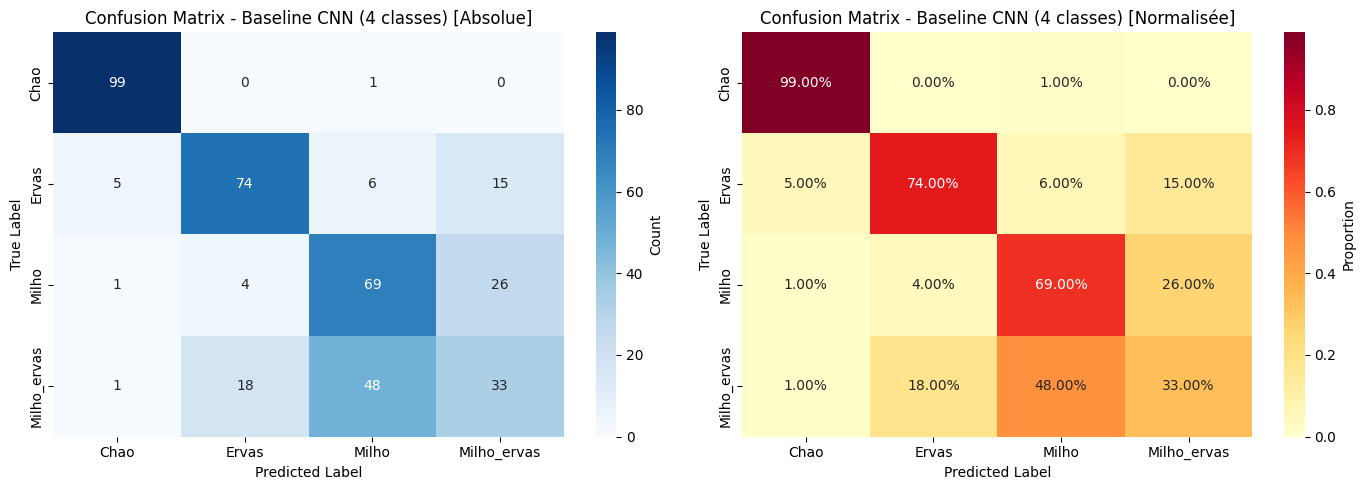


📋 Classification Report - Baseline CNN (4 CLASSES):
              precision    recall  f1-score   support

        Chao       0.93      0.99      0.96       100
       Ervas       0.77      0.74      0.76       100
       Milho       0.56      0.69      0.62       100
 Milho_ervas       0.45      0.33      0.38       100

    accuracy                           0.69       400
   macro avg       0.68      0.69      0.68       400
weighted avg       0.68      0.69      0.68       400


💾 SAUVEGARDE DU MODÈLE
✓ Modèle sauvegardé: ../model/baseline_cnn_4_best.pth
✓ Checkpoint complet: ../model/baseline_cnn_4_checkpoint.pt
✓ Test Accuracy: 68.75%
✓ Timestamp: 2025-12-18T13:33:08.393032

✓ Matrice de confusion affichée et modèle sauvegardé
✓ Modèle sauvegardé: ../model/baseline_cnn_4_best.pth
✓ Checkpoint complet: ../model/baseline_cnn_4_checkpoint.pt
✓ Test Accuracy: 68.75%
✓ Timestamp: 2025-12-18T13:33:08.393032

✓ Matrice de confusion affichée et modèle sauvegardé


In [56]:
# =============================================================================
# MATRICE DE CONFUSION - BASELINE CNN (4 CLASSES)
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report

print("\n" + "="*70)
print("🔍 MATRICE DE CONFUSION - BASELINE CNN (4 CLASSES)")
print("="*70)

# Charger le meilleur modèle
model_baseline_4.load_state_dict(torch.load('../model/baseline_cnn_4_best.pth'))
model_baseline_4.eval()

# Prédictions complètes
all_preds_4 = []
all_labels_4 = []

with torch.no_grad():
    for images, labels in test_loader_4:
        images, labels = images.to(device), labels.to(device)
        outputs = model_baseline_4(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_4.extend(predicted.cpu().numpy())
        all_labels_4.extend(labels.cpu().numpy())

# Matrice de confusion
cm_4 = confusion_matrix(all_labels_4, all_preds_4)
class_names_4 = sorted(class_to_idx_4.keys())

print("\n📊 Matrice de confusion (absolue):")
print(cm_4)

# Matrice normalisée
cm_normalized_4 = cm_4.astype('float') / cm_4.sum(axis=1)[:, np.newaxis]

print("\n📊 Matrice de confusion (normalisée par classe):")
print(cm_normalized_4)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice absolue
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_4, yticklabels=class_names_4,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Baseline CNN (4 classes) [Absolue]')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Matrice normalisée
sns.heatmap(cm_normalized_4, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names_4, yticklabels=class_names_4,
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix - Baseline CNN (4 classes) [Normalisée]')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*70)
print("📋 Classification Report - Baseline CNN (4 CLASSES):")
print("="*70)
print(classification_report(all_labels_4, all_preds_4, target_names=class_names_4))

# Sauvegarder le modèle entraîné
print("\n" + "="*70)
print("💾 SAUVEGARDE DU MODÈLE")
print("="*70)

# Sauvegarder l'état du modèle
torch.save(model_baseline_4.state_dict(), '../model/baseline_cnn_4_best.pth')

# Sauvegarder un checkpoint complet avec métadonnées
checkpoint = {
    'model_state': model_baseline_4.state_dict(),
    'architecture': 'BaselineCNN4',
    'num_classes': 4,
    'test_accuracy': 100 * correct_4 / total_4,
    'test_loss': test_loss_4,
    'confusion_matrix': cm_4,
    'class_names': class_names_4,
    'config': CONFIG,
    'timestamp': pd.Timestamp.now().isoformat()
}

checkpoint_path = '../model/baseline_cnn_4_checkpoint.pt'
torch.save(checkpoint, checkpoint_path)

print(f"✓ Modèle sauvegardé: ../model/baseline_cnn_4_best.pth")
print(f"✓ Checkpoint complet: {checkpoint_path}")
print(f"✓ Test Accuracy: {100 * correct_4 / total_4:.2f}%")
print(f"✓ Timestamp: {checkpoint['timestamp']}")

print("\n✓ Matrice de confusion affichée et modèle sauvegardé")

## 13c. Transfer Learning - ResNet50 (4 Classes)

In [43]:
# =============================================================================
# TRANSFER LEARNING: RESNET50 (4 CLASSES)
# =============================================================================

if stats_train_4:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - RESNET50 (4 CLASSES)")
    print("="*70)
    
    # Charger ResNet50 préentraîné
    resnet50_4 = models.resnet50(pretrained=True)
    
    # Geler les couches sauf les 2 derniers blocs
    for param in resnet50_4.layer1.parameters():
        param.requires_grad = False
    for param in resnet50_4.layer2.parameters():
        param.requires_grad = False
    
    # Remplacer le classifier pour 4 classes
    num_ftrs = resnet50_4.fc.in_features
    resnet50_4.fc = nn.Linear(num_ftrs, 4)  # 4 classes
    resnet50_4 = resnet50_4.to(device)
    
    print("✓ ResNet50 (4 classes) chargé")
    
    criterion_resnet50_4 = nn.CrossEntropyLoss()
    optimizer_resnet50_4 = optim.Adam(resnet50_4.parameters(), lr=CONFIG['learning_rate'])
    scheduler_resnet50_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet50_4, mode='min',
                                                               factor=0.5, patience=3)
    
    # Training
    print("⏱️  TRAINING RESNET50 (4 CLASSES)...")
    history_resnet50_4 = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss_resnet50_4 = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(resnet50_4, train_loader_4, criterion_resnet50_4,
                                           optimizer_resnet50_4, device)
        val_loss, val_acc = validate(resnet50_4, val_loader_4, criterion_resnet50_4, device)
        
        history_resnet50_4['train_loss'].append(train_loss)
        history_resnet50_4['val_loss'].append(val_loss)
        history_resnet50_4['train_acc'].append(train_acc)
        history_resnet50_4['val_acc'].append(val_acc)
        scheduler_resnet50_4.step(val_loss)
        
        if val_loss < best_val_loss_resnet50_4:
            best_val_loss_resnet50_4 = val_loss
            patience_counter = 0
            torch.save(resnet50_4.state_dict(), '../model/resnet50_4_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"⏹️  Early stopping à epoch {epoch+1}")
            break
    
    resnet50_4.load_state_dict(torch.load('../model/resnet50_4_best.pth'))
    
    # Évaluation
    resnet50_4.eval()
    test_loss_resnet50_4 = 0.0
    correct_resnet50_4 = 0
    total_resnet50_4 = 0
    
    with torch.no_grad():
        for images, labels in test_loader_4:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50_4(images)
            loss = criterion_resnet50_4(outputs, labels)
            test_loss_resnet50_4 += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_resnet50_4 += labels.size(0)
            correct_resnet50_4 += (predicted == labels).sum().item()
    
    test_acc_resnet50_4 = 100 * correct_resnet50_4 / total_resnet50_4
    test_loss_resnet50_4 = test_loss_resnet50_4 / len(test_loader_4)
    
    print(f"\nResNet50 (4 classes) - Test Loss: {test_loss_resnet50_4:.4f}")
    print(f"ResNet50 (4 classes) - Test Accuracy: {test_acc_resnet50_4:.2f}%")
    print("✓ ResNet50 (4 classes) terminé")


🔄 TRANSFER LEARNING - RESNET50 (4 CLASSES)
✓ ResNet50 (4 classes) chargé
⏱️  TRAINING RESNET50 (4 CLASSES)...
✓ ResNet50 (4 classes) chargé
⏱️  TRAINING RESNET50 (4 CLASSES)...
Epoch [1/1] - Train Loss: 0.7335, Val Loss: 0.4419
Epoch [1/1] - Train Loss: 0.7335, Val Loss: 0.4419

ResNet50 (4 classes) - Test Loss: 0.3725
ResNet50 (4 classes) - Test Accuracy: 87.00%
✓ ResNet50 (4 classes) terminé

ResNet50 (4 classes) - Test Loss: 0.3725
ResNet50 (4 classes) - Test Accuracy: 87.00%
✓ ResNet50 (4 classes) terminé



🔍 MATRICE DE CONFUSION - RESNET50 (4 CLASSES)

📊 Matrice de confusion (absolue):
[[99  0  1  0]
 [ 3 84  5  8]
 [ 1  2 84 13]
 [ 1  3 15 81]]

📊 Matrice de confusion (normalisée par classe):
[[0.99 0.   0.01 0.  ]
 [0.03 0.84 0.05 0.08]
 [0.01 0.02 0.84 0.13]
 [0.01 0.03 0.15 0.81]]

📊 Matrice de confusion (absolue):
[[99  0  1  0]
 [ 3 84  5  8]
 [ 1  2 84 13]
 [ 1  3 15 81]]

📊 Matrice de confusion (normalisée par classe):
[[0.99 0.   0.01 0.  ]
 [0.03 0.84 0.05 0.08]
 [0.01 0.02 0.84 0.13]
 [0.01 0.03 0.15 0.81]]


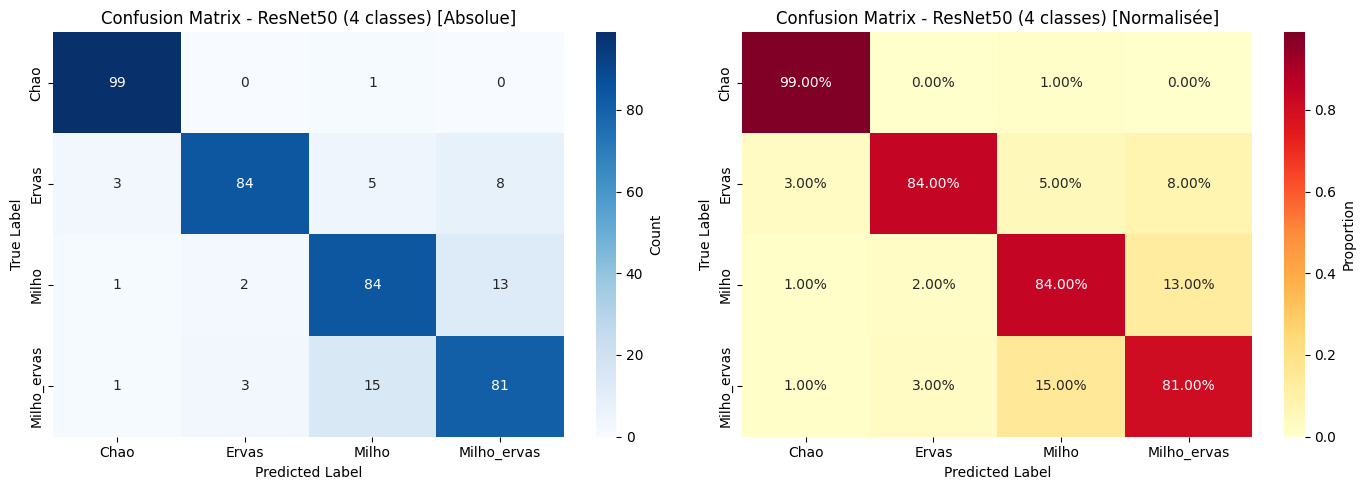


📋 Classification Report - RESNET50 (4 CLASSES):
              precision    recall  f1-score   support

        Chao       0.95      0.99      0.97       100
       Ervas       0.94      0.84      0.89       100
       Milho       0.80      0.84      0.82       100
 Milho_ervas       0.79      0.81      0.80       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400


✓ Matrice de confusion ResNet50 affichée


In [44]:
# =============================================================================
# MATRICE DE CONFUSION - RESNET50 (4 CLASSES)
# =============================================================================

if stats_train_4:
    from sklearn.metrics import confusion_matrix, classification_report
    
    print("\n" + "="*70)
    print("🔍 MATRICE DE CONFUSION - RESNET50 (4 CLASSES)")
    print("="*70)
    
    # Charger le meilleur modèle ResNet50 4-classes
    resnet50_4.load_state_dict(torch.load('../model/resnet50_4_best.pth'))
    resnet50_4.eval()
    
    # Prédictions complètes
    all_preds_resnet50_4 = []
    all_labels_resnet50_4 = []
    
    with torch.no_grad():
        for images, labels in test_loader_4:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50_4(images)
            _, predicted = torch.max(outputs, 1)
            all_preds_resnet50_4.extend(predicted.cpu().numpy())
            all_labels_resnet50_4.extend(labels.cpu().numpy())
    
    # Matrice de confusion
    cm_resnet50_4 = confusion_matrix(all_labels_resnet50_4, all_preds_resnet50_4)
    class_names_4 = sorted(class_to_idx_4.keys())
    
    print("\n📊 Matrice de confusion (absolue):")
    print(cm_resnet50_4)
    
    # Matrice normalisée
    cm_normalized_resnet50_4 = cm_resnet50_4.astype('float') / cm_resnet50_4.sum(axis=1)[:, np.newaxis]
    
    print("\n📊 Matrice de confusion (normalisée par classe):")
    print(cm_normalized_resnet50_4)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice absolue
    sns.heatmap(cm_resnet50_4, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_4, yticklabels=class_names_4,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix - ResNet50 (4 classes) [Absolue]')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Matrice normalisée
    sns.heatmap(cm_normalized_resnet50_4, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=class_names_4, yticklabels=class_names_4,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Confusion Matrix - ResNet50 (4 classes) [Normalisée]')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + "="*70)
    print("📋 Classification Report - RESNET50 (4 CLASSES):")
    print("="*70)
    print(classification_report(all_labels_resnet50_4, all_preds_resnet50_4, target_names=class_names_4))
    
    print("\n✓ Matrice de confusion ResNet50 affichée")

## 13e. Comparaison des Modèles (4 Classes)


📊 COMPARAISON DES MODÈLES (4 CLASSES)

----------------------------------------------------------------------
Model                Test Acc        Test Loss       Status              
----------------------------------------------------------------------
Baseline CNN          68.75%        0.6283          ✓ Trained           
VGG16                 25.00%        1.3865          ✓ Trained           
ResNet50              87.00%        0.3725          ✓ Trained           
----------------------------------------------------------------------

🏆 Meilleur modèle: ResNet50 avec 87.00% d'accuracy


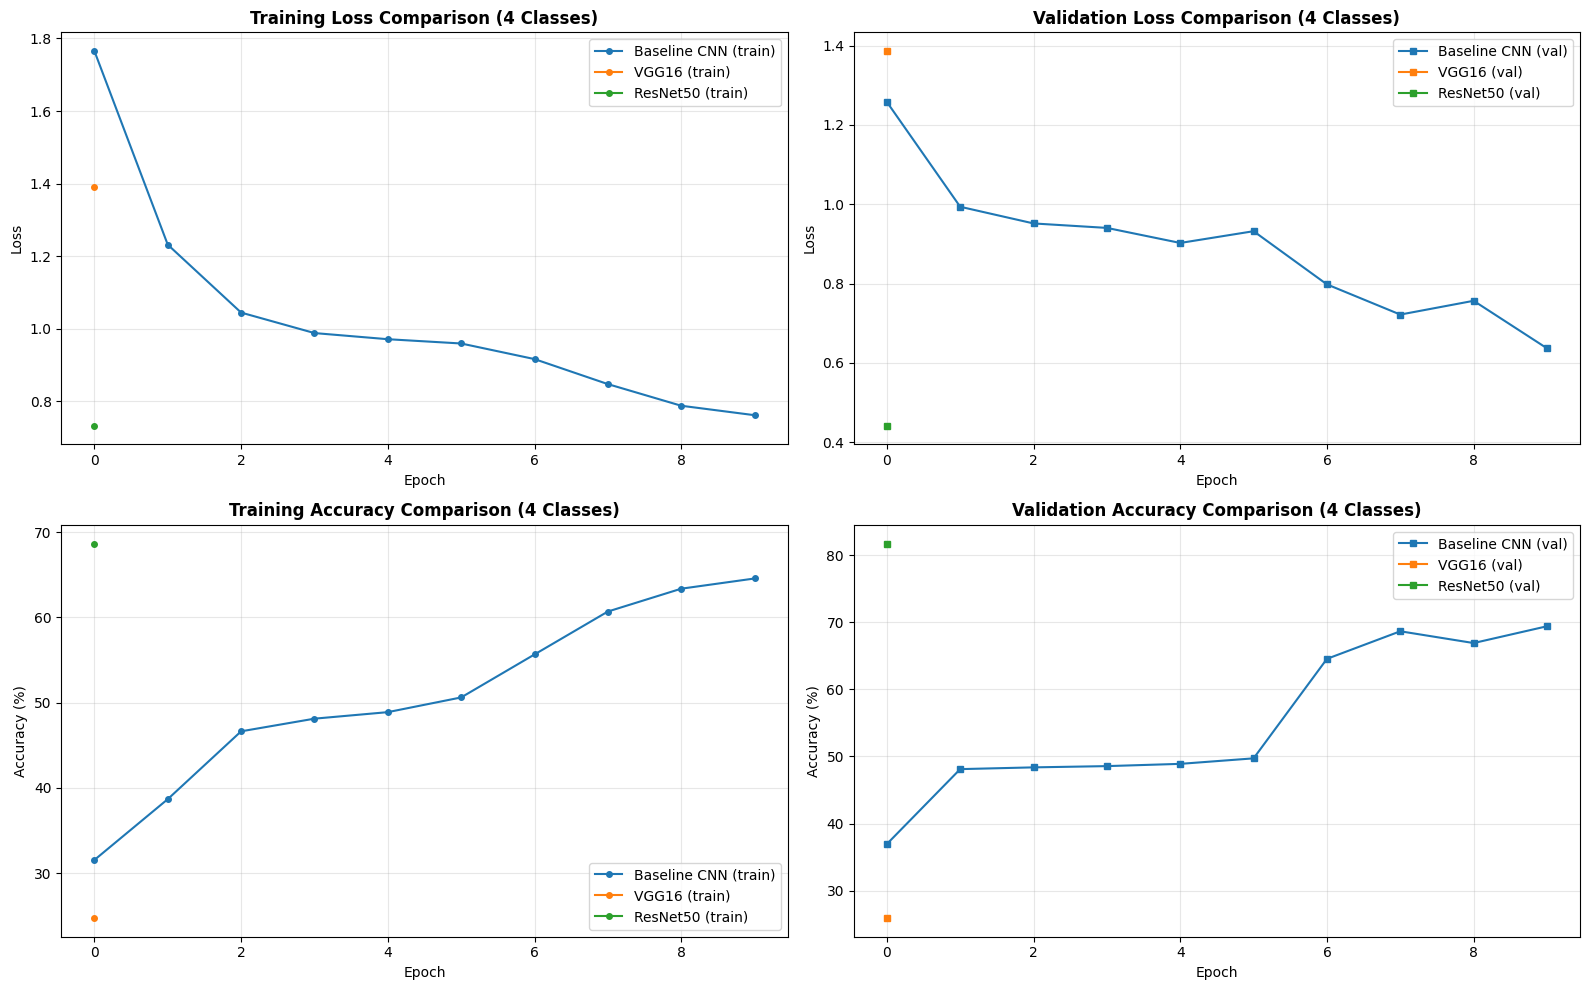

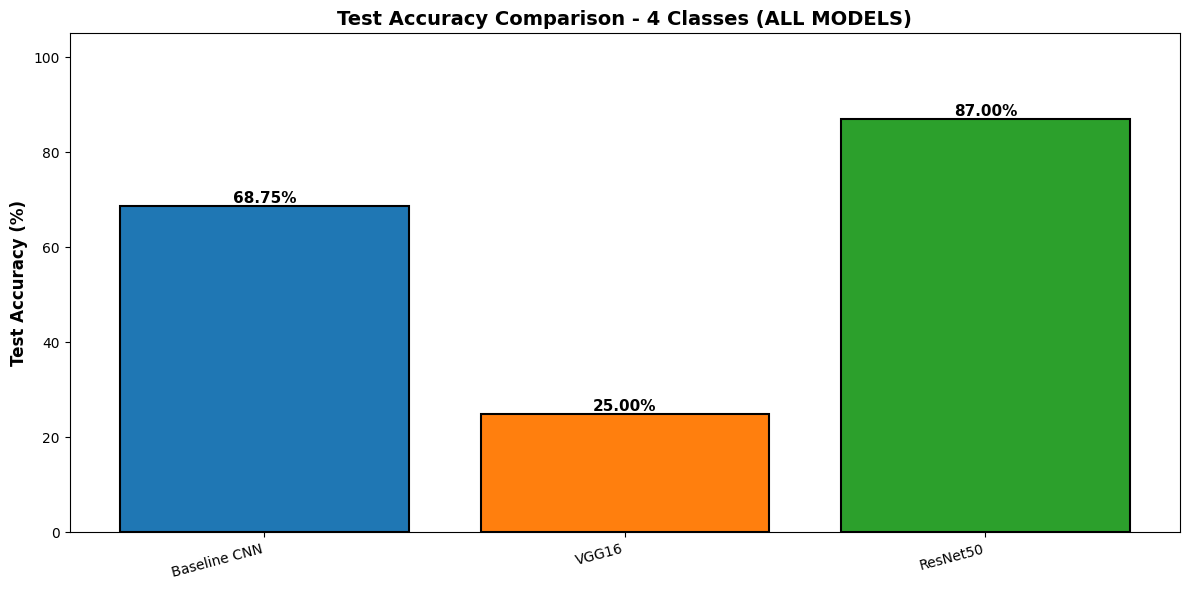


📈 RÉSUMÉ COMPARATIF - 4 CLASSES

Accuracy Statistics:
  Meilleur modèle:   87.00%
  Moins bon modèle:  25.00%
  Moyenne:           60.25%
  Écart:             62.00%

Nombre de modèles entrainés: 3/4

✓ Comparaison terminée


In [57]:
# =============================================================================
# COMPARAISON DES MODÈLES (4 CLASSES)
# =============================================================================

if stats_train_4:
    print("\n" + "="*70)
    print("📊 COMPARAISON DES MODÈLES (4 CLASSES)")
    print("="*70)
    
    # Résumé des accuracies et pertes
    results_4_classes = {
        'Baseline CNN': {
            'test_acc': test_acc_4,
            'test_loss': test_loss_4,
            'history': history_baseline_4
        },
        'VGG16': {
            'test_acc': test_acc_vgg16_4,
            'test_loss': test_loss_vgg16_4,
            'history': history_vgg16_4
        },
        'ResNet50': {
            'test_acc': test_acc_resnet50_4,
            'test_loss': test_loss_resnet50_4,
            'history': history_resnet50_4
        }
    }
    
    # Affichage des résultats en tableau
    print("\n" + "-"*70)
    print(f"{'Model':<20s} {'Test Acc':<15s} {'Test Loss':<15s} {'Status':<20s}")
    print("-"*70)
    
    best_model = None
    best_acc = 0
    
    for model_name, metrics in results_4_classes.items():
        acc = metrics['test_acc']
        loss = metrics['test_loss']
        if acc is not None:
            status = "✓ Trained" if metrics['history'] else "⚠ Failed"
            print(f"{model_name:<20s} {acc:>6.2f}%        {loss:>6.4f}          {status:<20s}")
            
            if acc > best_acc:
                best_acc = acc
                best_model = model_name
        else:
            print(f"{model_name:<20s} {'N/A':<14s} {'N/A':<14s} {'⚠ Not trained':<20s}")
    
    print("-"*70)
    if best_model:
        print(f"\n🏆 Meilleur modèle: {best_model} avec {best_acc:.2f}% d'accuracy")
    
    # Visualisation des courbes
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    models_to_plot = [
        ('Baseline CNN', results_4_classes['Baseline CNN']['history']),
        ('VGG16', results_4_classes['VGG16']['history']),
        ('ResNet50', results_4_classes['ResNet50']['history']),
    ]
    
    # Loss comparison
    axes[0, 0].set_title('Training Loss Comparison (4 Classes)', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[0, 0].plot(history['train_loss'], label=f'{model_name} (train)', 
                          marker='o', markersize=4)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Val Loss comparison
    axes[0, 1].set_title('Validation Loss Comparison (4 Classes)', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[0, 1].plot(history['val_loss'], label=f'{model_name} (val)',
                          marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Train Accuracy comparison
    axes[1, 0].set_title('Training Accuracy Comparison (4 Classes)', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[1, 0].plot(history['train_acc'], label=f'{model_name} (train)',
                          marker='o', markersize=4)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Val Accuracy comparison
    axes[1, 1].set_title('Validation Accuracy Comparison (4 Classes)', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[1, 1].plot(history['val_acc'], label=f'{model_name} (val)',
                          marker='s', markersize=4)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Bar chart - Final accuracies
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models_list = []
    accuracies = []
    colors_map = {
        'Baseline CNN': '#1f77b4',
        'VGG16': '#ff7f0e',
        'ResNet50': '#2ca02c',
    }
    
    for model_name, metrics in results_4_classes.items():
        if metrics['test_acc'] is not None:
            models_list.append(model_name)
            accuracies.append(metrics['test_acc'])
    
    colors = [colors_map[m] for m in models_list]
    bars = ax.bar(models_list, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Test Accuracy Comparison - 4 Classes (ALL MODELS)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 105])
    
    # Ajouter les valeurs sur les barres
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Résumé textuel
    print("\n" + "="*70)
    print("📈 RÉSUMÉ COMPARATIF - 4 CLASSES")
    print("="*70)
    
    # Trouver min et max
    valid_accs = [m['test_acc'] for m in results_4_classes.values() if m['test_acc'] is not None]
    if valid_accs:
        min_acc = min(valid_accs)
        max_acc = max(valid_accs)
        avg_acc = np.mean(valid_accs)
        
        print(f"\nAccuracy Statistics:")
        print(f"  Meilleur modèle:   {max_acc:.2f}%")
        print(f"  Moins bon modèle:  {min_acc:.2f}%")
        print(f"  Moyenne:           {avg_acc:.2f}%")
        print(f"  Écart:             {max_acc - min_acc:.2f}%")
        
        print(f"\nNombre de modèles entrainés: {len(valid_accs)}/4")
    
    print("\n✓ Comparaison terminée")

## 14. Interprétabilité avec LIME

### Explain Predictions:
- LIME (Local Interpretable Model-agnostic Explanations)
- Sélectionne les zones importantes pour la prédiction
- Visualise l'impact de chaque région



🔍 INTERPRÉTABILITÉ AVEC LIME


100%|██████████| 200/200 [00:00<00:00, 287.68it/s]

100%|██████████| 200/200 [00:00<00:00, 269.75it/s]



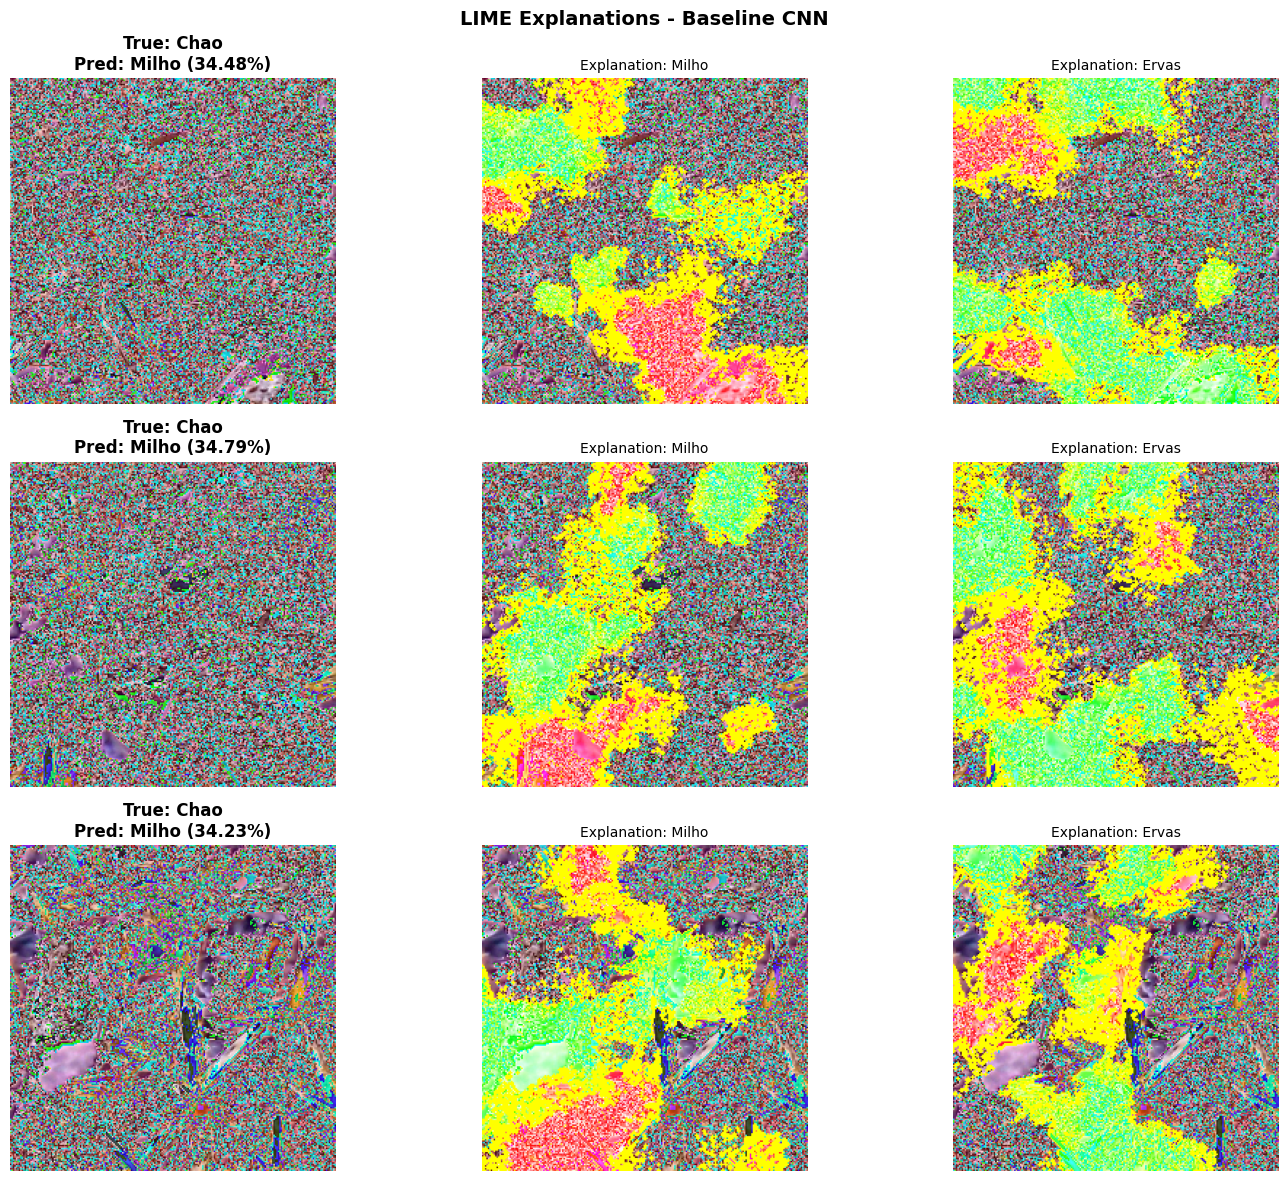


✓ LIME explanations générées


In [58]:
# =============================================================================
# INTERPRÉTABILITÉ AVEC LIME
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔍 INTERPRÉTABILITÉ AVEC LIME")
    print("="*70)
    
    # Fonction pour convertir image PIL en array normalisé
    def preprocess_image_for_model(pil_image):
        """Convertit une image PIL en tensor normalisé."""
        pil_image = pil_image.resize(CONFIG['img_size'])
        img_array = np.array(pil_image) / 255.0
        return img_array
    
    # Fonction de prédiction pour LIME
    def predict_fn_baseline(images):
        """Fonction de prédiction pour LIME (prend array numpy)."""
        model_baseline_3.eval()
        
        # Convertir images en tensors
        tensors = []
        for img in images:
            # Normaliser
            tensor = torch.from_numpy(img).permute(2, 0, 1).float()
            tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])(tensor)
            tensors.append(tensor)
        
        batch = torch.stack(tensors).to(device)
        
        with torch.no_grad():
            outputs = model_baseline_3(batch)
            probs = F.softmax(outputs, dim=1)
        
        return probs.cpu().numpy()
    
    # Sélectionner quelques images de test
    test_images = []
    test_labels_lime = []
    
    for images, labels in test_loader:
        if len(test_images) >= 3:
            break
        test_images.extend(images)
        test_labels_lime.extend(labels)
    
    # Initialiser LIME
    explainer = lime_image.LimeImageExplainer()
    
    # Expliquer les prédictions
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for idx in range(min(3, len(test_images))):
        img_pil = transforms.ToPILImage()(test_images[idx])
        img_array = preprocess_image_for_model(img_pil)
        
        # Prédiction
        pred_probs = predict_fn_baseline(np.array([img_array]))
        pred_class = np.argmax(pred_probs[0])
        pred_confidence = pred_probs[0][pred_class]
        true_class = test_labels_lime[idx].item()
        
        class_names_list = [idx_to_class[i] for i in range(len(idx_to_class))]
        
        # LIME explanation
        explanation = explainer.explain_instance(
            img_array,
            predict_fn_baseline,
            top_labels=3,
            hide_color=0,
            num_samples=200
        )
        
        # Image originale
        axes[idx, 0].imshow(img_array)
        axes[idx, 0].set_title(f"True: {class_names_list[true_class]}\n"
                              f"Pred: {class_names_list[pred_class]} "
                              f"({pred_confidence:.2%})",
                              fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Explications pour top 2 classes
        for class_idx in range(2):
            if class_idx < 2:
                temp, mask = explanation.get_image_and_mask(
                    explanation.top_labels[class_idx],
                    positive_only=False,
                    num_features=10,
                    hide_rest=False
                )
                
                axes[idx, class_idx + 1].imshow(mark_boundaries(temp, mask))
                axes[idx, class_idx + 1].set_title(
                    f"Explanation: {class_names_list[explanation.top_labels[class_idx]]}",
                    fontsize=10
                )
                axes[idx, class_idx + 1].axis('off')
    
    plt.suptitle('LIME Explanations - Baseline CNN', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ LIME explanations générées")

# Importer mark_boundaries
try:
    from skimage.segmentation import mark_boundaries
except:
    def mark_boundaries(img, boundaries):
        return img
